###Import and stuff

####pip installs and imports

In [ ]:
!pip install mne
!pip install skorch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import mne
from mne.preprocessing import Xdawn
import math
import sklearn
from scipy import stats

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix as cm
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

from collections import Counter
import sys
from random import choices
from random import shuffle
import random
import torch
import torch.nn as nn
import time

mne.set_log_level('ERROR')

     |████████████████████████████████| 7.0MB 31.7MB/s 
     |████████████████████████████████| 133kB 34.3MB/s 


####Set google connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


####Set needed values and load data

In [ ]:
torch.manual_seed(42) # set fixed random seed for reproducibility
cuda = True # Set this if training on GPU
cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Using "+repr(device))

Using device(type='cuda')


In [ ]:
event_dict = {'Good feedback': 1, 'Bad feedback': 0}
our_picks = ['Fz','Cz','P3','Pz','P4','PO7','PO8']

# Loading and reading fif files
train_epochs = mne.read_epochs('drive/MyDrive/BA thesis/Data/training-epo.fif',verbose='WARNING')
test_epochs = mne.read_epochs('drive/MyDrive/BA thesis/Data/test-epo.fif',verbose='WARNING')

all_epochs = mne.concatenate_epochs([train_epochs,test_epochs])
all_epochs.event_id=event_dict
all_epochs.rename_channels({'P08':'PO8'})

# all_epochs.crop(0.14, 0.65)

#Setting the 10-20 standard electrode locations
montage = mne.channels.make_standard_montage('standard_1020')
all_epochs.set_montage(montage,match_case=True, on_missing='warn')

Number of events,8840
Events,Bad feedback: 2579Good feedback: 6261
Time range,-0.250 – 1.000 sec
Baseline,-0.250 – 0.000 sec


In [ ]:
# vis_epochs = all_epochs.copy()
# vis_epochs.pick_channels(our_picks)

# vis_epochs[0].plot_image()
# vis_epochs[0].plot_psd_topomap()
# vis_epochs[0].plot_psd()
# vis_epochs[0].plot_topo_image()
# plt.show()

###Visualization of some figures

####Grand average of training set

In [ ]:
#Creating the indexes for splitting session 1-4 (training) from session 5 (testing)
#[0,1,2,3,4,...,238,239,340,341,342,...,578,579]
train_idxs = []
count = 0
for i in range(1,27):
    for j in range(240):
        train_idxs.append(j + count*340)
    count += 1

test_idxs = np.delete(np.arange(26*340),train_idxs)

In [ ]:
vis1 = all_epochs.copy().pick_channels(['Cz']).crop(-0.25,1)
# vis1 = vis1[train_idxs].apply_baseline(baseline=(-0.25,0))
vis1 = vis1.apply_baseline(baseline=(-0.25,0))
# vis1 = all_epochs.copy().pick_channels(['Cz']).crop(0.15,0.65)
# vis1 = vis1[train_idxs].apply_baseline(baseline=(0.15,0.65))
vis1_feedback = vis1.events[:,2]
vis1 = vis1.get_data()

In [ ]:
good_index = [i for i, j in enumerate(vis1_feedback) if j == 1]
bad_index = [i for i, j in enumerate(vis1_feedback) if j == 0]

good_means = pd.DataFrame(vis1.squeeze()).iloc[good_index].mean()
bad_means = pd.DataFrame(vis1.squeeze()).iloc[bad_index].mean()
diff_means = bad_means-good_means

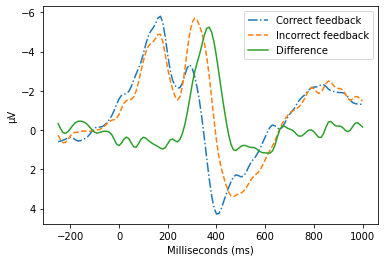

In [ ]:
x = np.arange(-250,1010,10)
# x = np.arange(0.15,0.66,0.01)
plt.plot(x,good_means,'-.', label = 'Correct feedback')
plt.plot(x,bad_means, '--',label = 'Incorrect feedback')
plt.plot(x,diff_means, label = 'Difference')
plt.legend()
plt.xlabel('Milliseconds (ms)')
plt.ylabel('\u03BCV')
plt.gca().invert_yaxis()

####Grand average across between sessions

In [ ]:
#Creating the indexes for splitting session 1-4 (training) from session 5 (testing)
#[0,1,2,3,4,...,238,239,340,341,342,...,578,579]
sess1 = []
sess2 = []
sess3 = []
sess4 = []

count = 0
for i in range(1,27):
    for j in range(60):
        sess1.append(j + count*340)
        sess2.append(j+60 + count*340)
        sess3.append(j+120 + count*340)
        sess4.append(j+180 + count*340)
    count += 1

test_idxs = np.delete(np.arange(26*340),train_idxs)

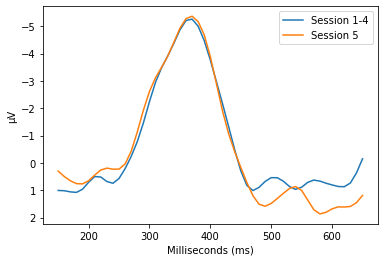

In [ ]:
x = np.arange(-250,1010,10)
x = np.arange(150,660,10)

# for sess in [sess1,sess2,sess3,sess4,test_idxs]:
for sess in [train_idxs,test_idxs]:
    vis1 = all_epochs.copy().pick_channels(['Cz']).crop(-0.25,1)
    vis1 = vis1[sess].apply_baseline(baseline=(-0.25,0))
    vis1.crop(0.15,0.65)

    # vis1 = all_epochs.copy().pick_channels(['Cz']).crop(0.15,0.65)
    # vis1 = vis1[train_idxs].apply_baseline(baseline=(0.15,0.65))
    vis1_feedback = vis1.events[:,2]
    vis1 = vis1.get_data()

    good_index = [i for i, j in enumerate(vis1_feedback) if j == 1]
    bad_index = [i for i, j in enumerate(vis1_feedback) if j == 0]

    good_means = pd.DataFrame(vis1.squeeze()).iloc[good_index].mean()
    bad_means = pd.DataFrame(vis1.squeeze()).iloc[bad_index].mean()
    diff_means = bad_means-good_means


# x = np.arange(0.15,0.66,0.01)
    plt.plot(x,diff_means)


plt.legend(['Session 1','Session 2','Session 3','Session 4','Session 5'])
plt.legend(['Session 1-4','Session 5'])
plt.xlabel('Milliseconds (ms)')
plt.ylabel('\u03BCV')
plt.gca().invert_yaxis()

####Visualizing the model performance

<BarContainer object of 3 artists>

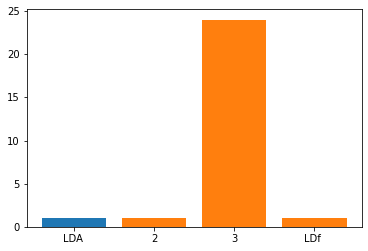

In [ ]:
#LDA vs CNN-LSTM
LDA_CNN = [1,1,24]

plt.bar(['LDA ','2','3'],LDA_CNN)
plt.bar(['LDf ','2','3'],LDA_CNN)

###Selecting and augmenting data

In [ ]:
#Creating the indexes for splitting session 1-4 (training) from session 5 (testing)
#[0,1,2,3,4,...,238,239,340,341,342,...,578,579]
train_idxs = []
count = 0
for i in range(1,27):
    for j in range(240):
        train_idxs.append(j + count*340)
    count += 1

test_idxs = np.delete(np.arange(26*340),train_idxs)

In [ ]:
#Function to make splits for training, validation and test sets. 
#i: subject_num, channel: channels to include, train_size: Percentage used for training, balance: bool for downsampling
from sklearn.model_selection import KFold

def balance_sampling_w_val_epoched(i,channel,train_size = 0.8, balance=False, fold_num = 5):
  Fz_epochs_0 = all_epochs.copy().pick_channels(channel).crop(0.15,0.62)[i*340:i*340+240].shift_time(0.01).apply_baseline(baseline=(0.16,0.63))
  Fz_epochs_1 = all_epochs.copy().pick_channels(channel).crop(0.16,0.63)[i*340:i*340+240].shift_time(0).apply_baseline(baseline=(0.16,0.63))
  Fz_epochs_4 = all_epochs.copy().pick_channels(channel).crop(0.18,0.65)[i*340:i*340+240].shift_time(-0.02).apply_baseline(baseline=(0.16,0.63))
  Fz_epochs_2 = all_epochs.copy().pick_channels(channel).crop(0.17,0.64)[i*340:i*340+240].shift_time(-0.01).apply_baseline(baseline=(0.16,0.63))
  Fz_epochs_3 = all_epochs.copy().pick_channels(channel).crop(0.14,0.61)[i*340:i*340+240].shift_time(0.02).apply_baseline(baseline=(0.16,0.63))

  length = len(Fz_epochs_0)
  #The training subsample 

  kf = KFold(n_splits=fold_num, shuffle = True, random_state=i) #setting random state to i in order for both reproducibility and also randomness between the subjects
  kf.get_n_splits(range(length))

  kf_list = list(kf.split(range(length)))

  all_kfolds = []
  for fold in range(fold_num):
    train_idx, val_idx = kf_list[fold]

    Fz_epochs_concat_train = mne.concatenate_epochs([Fz_epochs_0[train_idx],
                                            Fz_epochs_1[train_idx],
                                            Fz_epochs_2[train_idx],
                                            Fz_epochs_3[train_idx],
                                            Fz_epochs_4[train_idx]])
    Fz_labels_concat_train = Fz_epochs_concat_train.events[:,2]

    #The validation subsample
    Fz_epochs_concat_val = mne.concatenate_epochs([Fz_epochs_0[val_idx],
                                            Fz_epochs_1[val_idx],
                                            Fz_epochs_2[val_idx],
                                            Fz_epochs_3[val_idx],
                                            Fz_epochs_4[val_idx]])
    Fz_labels_concat_val = Fz_epochs_concat_val.events[:,2]

    #Upsample training 
    x_0 = Fz_epochs_concat_train[np.nonzero(Fz_labels_concat_train == 0)[0]]
    x_1 = Fz_epochs_concat_train[np.nonzero(Fz_labels_concat_train == 1)[0]]

    sample_size = min(len(x_0),len(x_1))
    y_0 = [0]*len(x_0)
    y_1 = [1]*len(x_1)

    if balance == True:

        idx_0 = np.random.choice(range(0,len(x_0)),size=sample_size,replace=False)
        idx_0 = np.sort(idx_0)
        x_0 = x_0[idx_0]

        idx_1 = np.random.choice(range(0,len(x_1)),size=sample_size,replace=False)
        idx_1 = np.sort(idx_1)
        x_1 = x_1[idx_1]
        
    x = mne.concatenate_epochs([x_0,x_1])
    y = np.concatenate((y_0,y_1))
    idx_shuffle_train = np.random.permutation(len(x))
    x_train, y_train = x[idx_shuffle_train], y[idx_shuffle_train]

    #upsample and shuffle validation?
    idx_shuffle_val = np.random.permutation(len(Fz_labels_concat_val))
    x_val, y_val = Fz_epochs_concat_val[idx_shuffle_val], Fz_labels_concat_val[idx_shuffle_val]

    x_test = all_epochs.copy().apply_baseline(baseline = (None, None)).pick_channels(channel).crop(0.16,0.63)[(i*340)+240:(i+1)*340]
    y_test = all_epochs.copy().apply_baseline(baseline = (None, None)).pick_channels(channel).crop(0.16,0.63)[(i*340)+240:(i+1)*340].events[:,2]

    all_kfolds.append((x_train, y_train, x_test, y_test, x_val, y_val))

  return all_kfolds

In [ ]:
#Function to make splits for training, validation and test sets. 
#i: subject_num, channel: channels to include, train_size: Percentage used for training, balance: bool for downsampling
def sampling_wo_folds(i,channel,train_size = 0.8, balance=False):
    Fz_epochs_0 = all_epochs.copy().pick_channels(channel).crop(0.15,0.62)[i*340:i*340+240].shift_time(0.01).apply_baseline(baseline=(0.16,0.63))
    Fz_epochs_1 = all_epochs.copy().pick_channels(channel).crop(0.16,0.63)[i*340:i*340+240].shift_time(0).apply_baseline(baseline=(0.16,0.63))
    Fz_epochs_4 = all_epochs.copy().pick_channels(channel).crop(0.18,0.65)[i*340:i*340+240].shift_time(-0.02).apply_baseline(baseline=(0.16,0.63))
    Fz_epochs_2 = all_epochs.copy().pick_channels(channel).crop(0.17,0.64)[i*340:i*340+240].shift_time(-0.01).apply_baseline(baseline=(0.16,0.63))
    Fz_epochs_3 = all_epochs.copy().pick_channels(channel).crop(0.14,0.61)[i*340:i*340+240].shift_time(0.02).apply_baseline(baseline=(0.16,0.63))

    length = len(Fz_epochs_0)
    #The training subsample 
    train_idx = np.random.choice(range(length),size=math.ceil(train_size * length),replace=False)
    val_idx = list(set(range(length)) - set(train_idx))

    train_idx = np.sort(train_idx)

    Fz_epochs_concat_train = mne.concatenate_epochs([Fz_epochs_0[train_idx],
                                            Fz_epochs_1[train_idx],
                                            Fz_epochs_2[train_idx],
                                            Fz_epochs_3[train_idx],
                                            Fz_epochs_4[train_idx]])
    Fz_labels_concat_train = Fz_epochs_concat_train.events[:,2]

    #The validation subsample
    Fz_epochs_concat_val = mne.concatenate_epochs([Fz_epochs_0[val_idx],
                                            Fz_epochs_1[val_idx],
                                            Fz_epochs_2[val_idx],
                                            Fz_epochs_3[val_idx],
                                            Fz_epochs_4[val_idx]])
    Fz_labels_concat_val = Fz_epochs_concat_val.events[:,2]

    #Upsample training 
    x_0 = Fz_epochs_concat_train[np.nonzero(Fz_labels_concat_train == 0)[0]]
    x_1 = Fz_epochs_concat_train[np.nonzero(Fz_labels_concat_train == 1)[0]]

    sample_size = min(len(x_0),len(x_1))
    y_0 = [0]*len(x_0)
    y_1 = [1]*len(x_1)
        
    x = mne.concatenate_epochs([x_0,x_1])
    y = np.concatenate((y_0,y_1))
    idx_shuffle_train = np.random.permutation(len(x))
    x_train, y_train = x[idx_shuffle_train], y[idx_shuffle_train]

    #upsample and shuffle validation?
    idx_shuffle_val = np.random.permutation(len(Fz_labels_concat_val))
    x_val, y_val = Fz_epochs_concat_val[idx_shuffle_val], Fz_labels_concat_val[idx_shuffle_val]

    x_test = all_epochs.copy().apply_baseline(baseline = (None, None)).pick_channels(channel).crop(0.16,0.63)[(i*340)+240:(i+1)*340]
    y_test = all_epochs.copy().apply_baseline(baseline = (None, None)).pick_channels(channel).crop(0.16,0.63)[(i*340)+240:(i+1)*340].events[:,2]

    return x_train, y_train, x_test, y_test, x_val, y_val

In [ ]:
sampling_wo_folds(0,our_picks)

##Modelling

####Evaluations and metric functions

In [ ]:
def make_preds(model, dataloader, states=None, limit = 0.5):    
    model.eval()
    list_preds = []
    list_probs = []
    for data, label in dataloader:
        data = data.to(device)
        label = label.to(device)
        if states != None:
            out, states = model(data,states)
        else:
            out = model(data)
        out = torch.sigmoid(out)
        list_probs.append(out.detach().cpu().numpy())
        out = torch.where(out >= limit, 1, 0)
        list_preds.append(out.detach().cpu().numpy()) # removed squeeze
    list_preds = np.concatenate(list_preds, axis=0).flatten()
    list_probs = np.concatenate(list_probs, axis=0).flatten()

    return list_preds, list_probs

def plot_hist(probs, labels):
    y_0 = np.array([probs[i] for i in range(len(labels)) if labels[i] == 0])
    y_1 = np.array([probs[i] for i in range(len(labels)) if labels[i] == 1])
    
    bins_0 = []
    bins_1 = []
    for i in range(10):
        count = len(y_0[(y_0 >= 0.1*i) & (y_0 <= 0.1*(i+1))])
        bins_0.append(count/len(y_0))
        count = len(y_1[(y_1 >= 0.1*i) & (y_1 <= 0.1*(i+1))])
        bins_1.append(count/len(y_1))

    axis_label = [str(i/10) + "-\n" + str((i+1)/10) for i in range(10)]

    fig, (axs1, axs2) = plt.subplots(1,2, sharey=True, figsize=(16,4))

    axs1.bar(axis_label, bins_0,alpha=0.5, color='red')
    axs2.bar(axis_label, bins_1,alpha=0.5, color='blue')
    
    axs1.set(ylabel='Percentages', title ='Probabilty distribution for ytrue = 0')
    axs2.set(ylabel='Percentages', title ='Probabilty distribution for ytrue = 1')
    
    plt.xticks(range(10))
    plt.ylim(0,1)

    for i in range(10):
        axs1.text(i-0.3,bins_0[i]+0.01,"{:2.0f}%".format(bins_0[i]*100))
        axs2.text(i-0.3,bins_1[i]+0.01,"{:2.0f}%".format(bins_1[i]*100))

    # plt.show()

In [ ]:
def evaluation(Y_true, Y_pred, pred_probs):

    # 0 = error, 1 = non-error
    TP = FP = FN = TN = 0

    for i in range(len(Y_true)):
        if Y_true[i] == Y_pred[i] == 0:
            TP += 1
        if Y_true[i] == 0 and Y_pred[i] == 1:
            FN += 1
        if Y_true[i] == 1 and Y_pred[i] == 0:
            FP += 1
        if Y_true[i] == Y_pred[i] == 1:
            TN += 1

    precision, recall, fscore, _ = precision_recall_fscore_support(Y_true, Y_pred)
    precision_w, recall_w, fscore_w, _ = precision_recall_fscore_support(Y_true, Y_pred, average='macro')

    #Consider setting average type. Default right now is average = macro
    auc = roc_auc_score(Y_true,pred_probs)

    return precision[0], precision[1], recall[0], recall[1], fscore[0], fscore[1], precision_w, recall_w, fscore_w, auc, TP, FP, TN, FN, recall[0]+recall[1]-1

In [ ]:
def plot_cm(clf,X_test,Y_test):
    np.set_printoptions(precision=3)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, Y_test,
                                    cmap=plt.cm.Blues,
                                    values_format='.5g')
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)
        
    plt.show()
    return None

In [ ]:
cols = ['ErrP prec', 'Non_ErrP prec', 'ErrP recall', 'Non_ErrP recall', 'ErrP f', 'Non_ErrP f', 'weighted prec', 'weighted recall', 'weighted_f', 'auc','TP','FP','TN','FN', 'Youdon']

####Prepping data for use in all models

In [ ]:
def transform_data(data, fitted_xdawn, fitted_scaler, fitted_vectorizer):
    data = fitted_xdawn.transform(data)    
    data = fitted_scaler.transform(data)
    data = fitted_vectorizer.transform(data)
    return data

class dataprepper(torch.utils.data.Dataset):
    def __init__(self, x_input, y_input):
        self.x_input = x_input.reshape((x_input.shape[0],1,x_input.shape[1]))
        self.y_input = y_input

    def __len__(self):
        return len(self.y_input)

    def __getitem__(self, index):
        x_output = self.x_input[index]
        y_output = self.y_input[index]

        return torch.Tensor(x_output), torch.from_numpy(np.array(y_output)).float() #torch.nn.functional.one_hot(torch.from_numpy(np.array(label)).long(),2).float()

In [ ]:
xdawn = Xdawn(n_components=5,correct_overlap='auto')
scale = mne.decoding.Scaler(scalings='mean')
vecto = mne.decoding.Vectorizer()

all_subjects_fold = []

for i in range(26):
    print("subject: " + str(i))
    subject_w_5fold = balance_sampling_w_val_epoched(i, our_picks,0.80,balance=False)
    subject_fold = []

    for fold in range(5):
        xtrain,ytrain,xtest,ytest, xval, yval = subject_w_5fold[fold]

        xtrain = xdawn.fit_transform(xtrain)
        xtrain = scale.fit_transform(xtrain)
        xtrain = vecto.fit_transform(xtrain)

        xval = transform_data(xval,xdawn,scale,vecto)
        xtest = transform_data(xtest,xdawn,scale,vecto)

        subject_fold.append((xtrain, ytrain, xtest, ytest, xval, yval))

    all_subjects_fold.append(subject_fold)

#The all_subjects_fold has structure subject X fold X dataset: [subX [foldX [xtrain, ytrain, ...]]

subject: 0
subject: 1
subject: 2
subject: 3
subject: 4
subject: 5
subject: 6
subject: 7
subject: 8
subject: 9
subject: 10
subject: 11
subject: 12
subject: 13
subject: 14
subject: 15
subject: 16
subject: 17
subject: 18
subject: 19
subject: 20
subject: 21
subject: 22
subject: 23
subject: 24
subject: 25


In [ ]:
xdawn = Xdawn(n_components=5,correct_overlap='auto')
scale = mne.decoding.Scaler(scalings='mean')
vecto = mne.decoding.Vectorizer()

all_subjects_cross = []

for i in range(26):
    print("subject: " + str(i))
    xtrain,ytrain,xtest,ytest, xval, yval = sampling_wo_folds(i, our_picks,0.80)

    xtrain = xdawn.fit_transform(xtrain)
    xtrain = scale.fit_transform(xtrain)
    xtrain = vecto.fit_transform(xtrain)

    xval = transform_data(xval,xdawn,scale,vecto)
    xtest = transform_data(xtest,xdawn,scale,vecto)

    all_subjects_cross.append((xtrain, ytrain, xtest, ytest, xval, yval))

#The all_subjects_fold has structure subject X fold X dataset: [subX [foldX [xtrain, ytrain, ...]]

subject: 0


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 1


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 2


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 3


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 4


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 5


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 6


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 7


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 8


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 9


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 10


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 11


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 12


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 13


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 14


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 15


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 16


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 17


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 18


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 19


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 20


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 21


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 22


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 23


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 24


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


subject: 25


<ipython-input-42-01b77d542400>:29: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  Fz_epochs_4[val_idx]])


In [ ]:
# # distribution of labels
# ones_percents = []
# for subject in all_subjects:
#     positive_rate_train = sum(subject[1])/len(subject[1])
#     positive_rate_test = sum(subject[3])/len(subject[3])
#     ones_percents.append([positive_rate_train,positive_rate_test])
# ones_df = pd.DataFrame(ones_percents,columns=['spell acc train','spell acc test'])
# ones_df['spell diff'] = ones_df['spell acc train'].subtract(ones_df['spell acc test'])

###Setup the classifiers

####Dummy classifier and LDA + training loop

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.base import clone

clf_most_f = DummyClassifier(strategy = 'most_frequent')
clf_uniform = DummyClassifier(strategy = 'uniform')
clf_lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto')

In [ ]:
def train_loop(clf, subject):

    evaluations = []
    models = []

    for fold in range(5):
        print("Fold: " + str(fold))
        xtrain,ytrain,xtest,ytest, xval, yval = all_subjects_fold[subject][fold]

        clf_subject = clone(clf)
        clf_subject.fit(xtrain,ytrain)
        subject_pred = clf_subject.predict(xtest)
        subject_pred_probs = clf_subject.predict_proba(xtest)

        eval_metrics = evaluation(ytest, subject_pred, subject_pred_probs[:,-1])
        evaluations.append(eval_metrics)
        models.append(clf_subject)
    
    return evaluations, models

def train_loop_cross(clf):

    evaluations = []
    models = []

    for sub in range(26):
        print("Sub: " + str(sub))

        xtrain,ytrain,xtest,ytest, xval, yval = all_subjects_cross[sub]

        clf_subject = clone(clf)
        clf_subject.fit(xtrain,ytrain)
        subject_pred = clf_subject.predict(xtest)
        subject_pred_probs = clf_subject.predict_proba(xtest)

        eval_metrics = evaluation(ytest, subject_pred, subject_pred_probs[:,-1])
        evaluations.append(eval_metrics)
        models.append(clf_subject)
    
    return evaluations, models

####CNN + LSTM Model

In [ ]:
lstm_layers = 2
lstm_dim = 64
dropout_prob = 0.1

class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()

        self.batch_norm0 = nn.BatchNorm1d(1)
        self.cv1d_1 = nn.Conv1d(1,64,padding=1,kernel_size=3)
        self.cv1d_2 = nn.Conv1d(64,128,padding=1,kernel_size=3)
        self.cv1d_3 = nn.Conv1d(128,256,padding=1,kernel_size=3)
        self.cv1d_4 = nn.Conv1d(256,512,padding=1,kernel_size=3)

        self.dropout1 = nn.Dropout(p=dropout_prob)

        self.fc1 = nn.Linear(512,256)

        self.LSTM = nn.LSTM(input_size = 256, hidden_size = lstm_dim, num_layers=lstm_layers, batch_first=True, dropout=dropout_prob)

        self.maxpool1 = nn.MaxPool1d(kernel_size=2,ceil_mode=True)
        self.relu = nn.ReLU(inplace=True)

        self.lin1 = nn.Linear(64*240,256)
        self.lin2 = nn.Linear(256,128)
        self.lin3 = nn.Linear(128,64)
        self.lin4 = nn.Linear(64,1)

        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.LSTM.named_parameters())
        for n in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)   

    def forward(self, x, states):

        out = self.relu(self.cv1d_1(x))
        out = self.maxpool1(out) #reduced length to 480 -> 240

        out = self.relu(self.cv1d_2(out))    
        out = self.relu(self.cv1d_3(out))
        out = self.relu(self.cv1d_4(out)) #ends with 512 features

        batch, features, seq_len = out.size()

        out = out.view(batch, seq_len, features)

        out = self.fc1(out)
        batch, features, seq_len = out.size()

        out = self.dropout1(out)
        lstm_in = out.view(batch,240,256) #lstm_in: batch, seq_len, features

        lstm_out, states = self.LSTM(lstm_in, states)

        batch, seq_len, features = out.size()

        lstm_out = lstm_out.reshape(batch, seq_len*lstm_dim)

        #Linear layers
        out = self.lin1(lstm_out)
        out = self.lin2(out)
        out = self.lin3(out)
        out = self.lin4(out)
        
        return out, states

In [ ]:
def detach(states):
    return [state.detach() for state in states]

def eval_cnn_lstm(model, valid_loader, loss_fn, states):
    model.eval()

    val_loss = 0
    with torch.no_grad():
        for batch, label in valid_loader:
            batch = batch.to(device)
            label = label.to(device)
            
            out, states = model(batch, states)
            loss = loss_fn(out.squeeze(), label.squeeze())
            val_loss += loss.item()

    return val_loss

def cnn_lstm_train_loop(model, train_loader, optimizer, loss_fn, device,epochs,valid_loader = None):

    best_model = model.state_dict()
    best_val_loss = 1
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        states = (torch.zeros(lstm_layers, 20, lstm_dim).to(device), torch.zeros(lstm_layers, 20, lstm_dim).to(device))
        
        for batch, label in train_loader:
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad(set_to_none=True)
            states = detach(states)
            out, states = model(batch, states)

            loss = loss_fn(out.squeeze(), label.squeeze())
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        val_loss = eval_cnn_lstm(model, valid_loader, loss_fn, states)

        if (epoch+1) % 10 == 0 or epoch == 0:
            print('=>Epoch: {} Train loss: {:.4f}, Val loss: {:.4f}, Time epoch: {:.2f}'.format(epoch+1, train_loss/len(train_loader), val_loss/len(valid_loader), time.time() - start_time))
            start_time = time.time()

        if val_loss < best_val_loss:
            best_model = model.state_dict()
            best_val_loss = val_loss
    
    model.load_state_dict(best_model)

    return model, states

In [ ]:
# input_test = torch.randn(10,1,480).to(device)
# states = (torch.zeros(lstm_layers, 10, lstm_dim).to(device),
#               torch.zeros(lstm_layers, 10, lstm_dim).to(device))
# model = BaseCNN().to(device)
# output, states = model(input_test, states)
# print(torch.sigmoid(output))

####UNet

In [ ]:
def double_conv(in_channels, out_channels):
  conv = nn.Sequential(
      nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
      torch.nn.BatchNorm1d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
      torch.nn.BatchNorm1d(out_channels),
      nn.ReLU(inplace=True),
  )
  return conv.float()

class UNet(nn.Module):

  def __init__(self):
    
    super(UNet,self).__init__()

    # contraction
    self.down_conv_1 = double_conv(1,64)
    self.down_conv_2 = double_conv(64,128)
    self.down_conv_3 = double_conv(128,256)
    self.down_conv_4 = double_conv(256,512)
    self.down_conv_5 = double_conv(512,1024)
    # max pooling
    self.max_pool = nn.MaxPool1d(kernel_size=2, stride=2, ceil_mode=True)
    # expansion 
    self.up_2x2conv_1 = nn.ConvTranspose1d(1024, 512, kernel_size=2, stride=2).float()
    self.up_2x2conv_2 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2).float()
    self.up_2x2conv_3 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2).float()
    self.up_2x2conv_4 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2).float()
    self.up_double_conv_1 = double_conv(1024,512) 
    self.up_double_conv_2 = double_conv(512, 256) 
    self.up_double_conv_3 = double_conv(256,128)
    self.up_double_conv_4 = double_conv(128,64)
    # output
    self.out = nn.Linear(64*480,1) #batch_size * seq_len
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, image):
    # encoder
    conv1 = self.down_conv_1(image) 
    pool1 = self.max_pool(conv1)
    conv2 = self.down_conv_2(pool1) 
    pool2 = self.max_pool(conv2)
    conv3 = self.down_conv_3(pool2) 
    pool3 = self.max_pool(conv3)
    conv4 = self.down_conv_4(pool3)
    pool4 = self.max_pool(conv4)
    conv5 = self.down_conv_5(pool4)
    
    # decoder
    x = self.up_2x2conv_1(conv5)
    x = torch.cat((x,conv4),1)
    x = self.up_double_conv_1(x)
    
    x = self.up_2x2conv_2(x)
    x = torch.cat((x,conv3),1)
    x = self.up_double_conv_2(x)

    x = self.up_2x2conv_3(x)
    x = torch.cat((x,conv2),1)
    x = self.up_double_conv_3(x)

    x = self.up_2x2conv_4(x)
    x = torch.cat((x,conv1),1)
    x = self.up_double_conv_4(x)
    x = x.reshape((x.shape[0],64*480))

    out = self.out(x)
    out = self.dropout(out)

    return out

class ShortUNet(nn.Module):

  def __init__(self):
    super(ShortUNet,self).__init__()

    # contraction
    self.down_conv_1 = double_conv(1,64)
    self.down_conv_2 = double_conv(64,128)
    self.down_conv_3 = double_conv(128,256)
    self.down_conv_4 = double_conv(256,512)
    self.down_conv_5 = double_conv(512,1024)
    # max pooling
    self.max_pool = nn.MaxPool1d(kernel_size=2, stride=2, ceil_mode=True)
    # expansion 
    self.up_2x2conv_1 = nn.ConvTranspose1d(1024, 512, kernel_size=2, stride=2).float()
    self.up_2x2conv_2 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2).float()
    self.up_2x2conv_3 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2).float()
    self.up_2x2conv_4 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2).float()
    self.up_double_conv_1 = double_conv(1024,512) 
    self.up_double_conv_2 = double_conv(512, 256) 
    self.up_double_conv_3 = double_conv(256,128)
    self.up_double_conv_4 = double_conv(128,64)
    # output
    #self.out = nn.Conv1d(in_channels=64, out_channels=1, kernel_size=1).double()
    self.out = nn.Linear(64*480,1)
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, image):
    # encoder
    conv1 = self.down_conv_1(image) 
    pool1 = self.max_pool(conv1)
    conv2 = self.down_conv_2(pool1) 
    pool2 = self.max_pool(conv2)
    conv3 = self.down_conv_3(pool2) 
    pool3 = self.max_pool(conv3)
    conv4 = self.down_conv_4(pool3)
    
    # decoder
    x = self.up_2x2conv_2(conv4)
    x = torch.cat((x,conv3),1)
    x = self.up_double_conv_2(x)

    x = self.up_2x2conv_3(x)
    x = torch.cat((x,conv2),1)
    x = self.up_double_conv_3(x)

    x = self.up_2x2conv_4(x)
    x = torch.cat((x,conv1),1)
    x = self.up_double_conv_4(x)
    x = x.reshape((x.shape[0],64*480))
    
    # output
    out = self.out(x)
    out = self.dropout(out)

    return out

class ShortUNet_red_dim(nn.Module):

  def __init__(self):
    super(ShortUNet_red_dim,self).__init__()

    # contraction
    self.down_conv_1 = double_conv(1,32)
    self.down_conv_2 = double_conv(32,64)
    self.down_conv_3 = double_conv(64,128)
    self.down_conv_4 = double_conv(128,256)
    # max pooling
    self.max_pool = nn.MaxPool1d(kernel_size=2, stride=2, ceil_mode=True)
    # expansion 
    self.up_2x2conv_1 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2).float()
    self.up_2x2conv_2 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2).float()
    self.up_2x2conv_3 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2).float()
    self.up_2x2conv_4 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2).float()
    self.up_double_conv_1 = double_conv(512,256) 
    self.up_double_conv_2 = double_conv(256,128) 
    self.up_double_conv_3 = double_conv(128,64)
    self.up_double_conv_4 = double_conv(64,32)
    # output
    #self.out = nn.Conv1d(in_channels=64, out_channels=1, kernel_size=1).double()
    self.out = nn.Linear(32*480,1)
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, image):
    # encoder
    conv1 = self.down_conv_1(image) 
    pool1 = self.max_pool(conv1)
    conv2 = self.down_conv_2(pool1) 
    pool2 = self.max_pool(conv2)
    conv3 = self.down_conv_3(pool2) 
    pool3 = self.max_pool(conv3)
    conv4 = self.down_conv_4(pool3)
    
    # decoder
    x = self.up_2x2conv_2(conv4)
    x = torch.cat((x,conv3),1)
    x = self.up_double_conv_2(x)

    x = self.up_2x2conv_3(x)
    x = torch.cat((x,conv2),1)
    x = self.up_double_conv_3(x)

    x = self.up_2x2conv_4(x)
    x = torch.cat((x,conv1),1)
    x = self.up_double_conv_4(x)
    x = x.reshape((x.shape[0],32*480))
    
    # output
    out = self.out(x)
    out = self.dropout(out)

    return out

In [ ]:
def eval_UNet(model, valid_loader, loss_fn):
    model.eval()

    val_loss = 0
    with torch.no_grad():
        for batch, label in valid_loader:
            batch = batch.to(device)
            label = label.to(device)     
            out = model(batch)
            loss = loss_fn(out.squeeze(), label.squeeze())
            val_loss += loss.item()

    return val_loss

def train_loop_UNet(model, train_loader, optimizer, loss_fn, device,epochs,valid_loader = None):

    best_model = model.state_dict()
    best_val_loss = 1
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch, label in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            label = label.to(device)
            out = model(batch)
            loss = loss_fn(out.view(-1),label)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = eval_UNet(model, valid_loader, loss_fn)

        if (epoch+1) % 10 == 0 or epoch == 0:
            print('=>Epoch: {} Train loss: {:.4f}, Val loss: {:.4f}, Time epoch: {:.2f}'.format(epoch+1, train_loss/len(train_loader), val_loss/len(valid_loader), time.time() - start_time))
            start_time = time.time()

        if val_loss < best_val_loss:
            best_model = model.state_dict()
            best_val_loss = val_loss

    model.load_state_dict(best_model)

    return model

####Loop for Neural network

In [ ]:
batch_size = 64
epochs = 10
lr = 1e-4
loss_fn = nn.BCEWithLogitsLoss()

def Neural_loop(model, subject, loop, lr, epochs,Unet = True, limit = 0.5, batch = batch_size):
    all_evaluations = []
    all_models = []
    all_states = []
    batch_sz = batch

    for fold in range(5):
        print("Fold: " + str(fold))
        xtrain,ytrain,xtest,ytest, xval, yval = all_subjects_fold[subject][fold]

        train_prepper = dataprepper(xtrain,ytrain)
        val_prepper = dataprepper(xval,yval)
        test_prepper = dataprepper(xtest,ytest)

        if Unet == False:
            batch_sz = 20

        train_loader =  torch.utils.data.DataLoader(train_prepper, batch_size = batch_sz, num_workers=2,pin_memory=True)
        val_loader =  torch.utils.data.DataLoader(val_prepper, batch_size = batch_sz, num_workers=2,pin_memory=True)
        test_loader =  torch.utils.data.DataLoader(test_prepper, batch_size = batch_sz, num_workers=2,pin_memory=True)

        if Unet == True:
            model = ShortUNet().to(device)
            optim = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-4)
            outmodel = loop(model, train_loader,optim, loss_fn, device,epochs, val_loader)
            preds_, probs_ = make_preds(outmodel, test_loader,limit=limit)
        else:
            model = BaseCNN().to(device)
            optim = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-4)
            outmodel, out_states = loop(model, train_loader,optim, loss_fn, device,epochs, val_loader)
            preds_, probs_ = make_preds(outmodel, test_loader,out_states,limit=limit)
            all_states.append(out_states)

        eval_metrics = evaluation(ytest, preds_, probs_)
        all_evaluations.append(eval_metrics)
        all_models.append(outmodel)

    if Unet == True:
        return all_evaluations, all_models
    else:
        return all_evaluations, all_models, all_states

def Neural_loop_cross(model, subject, loop, lr, epochs,Unet = True, limit = 0.5, batch = batch_size):
    all_evaluations = []
    all_models = []
    all_states = []
    batch_sz = batch

    for sub in range(26):
        print("Sub: " + str(sub))
        xtrain,ytrain,xtest,ytest, xval, yval = all_subjects_cross[sub]

        train_prepper = dataprepper(xtrain,ytrain)
        val_prepper = dataprepper(xval,yval)
        test_prepper = dataprepper(xtest,ytest)

        if Unet == False:
            batch_sz = 20

        train_loader =  torch.utils.data.DataLoader(train_prepper, batch_size = batch_sz, num_workers=2,pin_memory=True)
        val_loader =  torch.utils.data.DataLoader(val_prepper, batch_size = batch_sz, num_workers=2,pin_memory=True)
        test_loader =  torch.utils.data.DataLoader(test_prepper, batch_size = batch_sz, num_workers=2,pin_memory=True)

        if Unet == True:
            model = ShortUNet().to(device)
            optim = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-4)
            outmodel = loop(model, train_loader,optim, loss_fn, device,epochs, val_loader)
            preds_, probs_ = make_preds(outmodel, test_loader,limit=limit)
        else:
            model = BaseCNN().to(device)
            optim = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-4)
            outmodel, out_states = loop(model, train_loader,optim, loss_fn, device,epochs, val_loader)
            preds_, probs_ = make_preds(outmodel, test_loader,out_states,limit=limit)
            all_states.append(out_states)

        eval_metrics = evaluation(ytest, preds_, probs_)
        all_evaluations.append(eval_metrics)
        all_models.append(outmodel)

    if Unet == True:
        return all_evaluations, all_models
    else:
        return all_evaluations, all_models, all_states

In [ ]:
batch_size = 64
epochs = 10
lr = 1e-4
loss_fn = nn.BCEWithLogitsLoss()

def Neural_loop_gr_search(model, loop, lr, epochs,Unet = True, limit=0.5):
    all_evaluation = []
    all_models = []

    for subject in range(26):
        print("Subject: " + str(subject))
        xtrain,ytrain,xtest,ytest, xval, yval = all_subjects[subject]

        train_prepper = dataprepper(xtrain,ytrain)
        val_prepper = dataprepper(xval,yval)

        train_loader =  torch.utils.data.DataLoader(train_prepper, batch_size = batch_size, num_workers=2,pin_memory=True)
        val_loader =  torch.utils.data.DataLoader(val_prepper, batch_size = batch_size, num_workers=2,pin_memory=True)

        model = model
        optim = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-4)

        if Unet == True:
            outmodel = loop(model, train_loader,optim, loss_fn, device,epochs, val_loader)
            preds_, probs_ = make_preds(outmodel, val_loader,limit=limit)
            all_models.append(outmodel)
        else:
            outmodel, out_states = loop(model, train_loader,optim, loss_fn, device,epochs, val_loader)
            preds_, probs_ = make_preds(outmodel, val_loader,out_states,limit=limit)
            all_models.append((outmodel,out_states))

        eval_metrics = evaluation(yval, preds_, probs_)
        all_evaluation.append(eval_metrics)
        

    if Unet == True:
        return all_evaluation, all_models
    else:
        return all_evaluation, all_models

###Model classification

####1. Results LDA classifier

In [ ]:
all_evaluation_LDA, all_model_lda = train_loop(clf_lda)

In [ ]:
cols = ['ErrP prec', 'Non_ErrP prec', 'ErrP recall', 'Non_ErrP recall', 'ErrP f', 'Non_ErrP f', 'weighted prec', 'weighted recall', 'weighted_f', 'auc','TP','FP','TN','FN', 'Youdon']

all_evaluation_means_lda = []
for limit in np.linspace(0.05,0.95,19):
    all_evaluation = []
    for i in range(26):
        xtrain,ytrain,xtest,ytest, xval, yval = all_subjects[i]
        
        list_prob = all_model_lda[i].predict_proba(xval)[:,1]
        list_pred = np.where(list_prob >= limit,1,0)
        eval_metrics = evaluation(yval, list_pred, list_prob)

        all_evaluation.append(eval_metrics)

    all_evaluation_means_lda.append(pd.DataFrame(all_evaluation,columns=cols).mean())

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


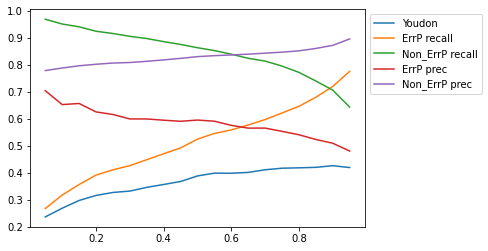

In [ ]:
pd.DataFrame(all_evaluation_means_lda,columns=cols)
plt.plot(np.linspace(0.05,0.95,19),pd.DataFrame(all_evaluation_means_lda,columns=cols)['Youdon'])
plt.plot(np.linspace(0.05,0.95,19),pd.DataFrame(all_evaluation_means_lda,columns=cols)['ErrP recall'])
plt.plot(np.linspace(0.05,0.95,19),pd.DataFrame(all_evaluation_means_lda,columns=cols)['Non_ErrP recall'])
plt.plot(np.linspace(0.05,0.95,19),pd.DataFrame(all_evaluation_means_lda,columns=cols)['ErrP prec'])
plt.plot(np.linspace(0.05,0.95,19),pd.DataFrame(all_evaluation_means_lda,columns=cols)['Non_ErrP prec'])
plt.legend(['Youdon','ErrP recall','Non_ErrP recall','ErrP prec','Non_ErrP prec'],loc='best',bbox_to_anchor=(1,1))

In [ ]:
subject_iterations = []
for iteration in range(5):
    all_evaluation_LDA, all_model_lda = train_loop(clf_lda)
    subject_iterations.append(all_evaluation_LDA)

####Results UNET

In [ ]:
all_evaluation_UNET, UNET_model = Neural_loop(UNet().to(device),train_loop_UNet,epochs,Unet=True)

In [ ]:
grid_epochs = [10,20]
grid_lr = [1e-3,1e-4,1e-5]
# grid_model = [UNet().to(device),ShortUNet().to(device)]

grid_search = []

for gr_epoch in grid_epochs:
    for gr_lr in grid_lr:
        # for gr_model in grid_model:
        print(str(gr_epoch) + " " + str(gr_lr))
        all_evaluation_UNET, UNET_model = Neural_loop_gr_search(UNet().to(device),train_loop_UNet,gr_lr, gr_epoch,Unet=True)
        grid_search.append((str(gr_epoch) + " " + str(gr_lr),all_evaluation_UNET, UNET_model))

In [ ]:
_, list_of_model = Neural_loop_gr_search(ShortUNet().to(device),train_loop_UNet,1e-4,10)

In [ ]:

xtrain,ytrain,xtest,ytest, xval, yval = all_subjects[0]
train_prepper = dataprepper(xtrain,ytrain)
val_prepper = dataprepper(xval,yval)

train_loader =  torch.utils.data.DataLoader(train_prepper, batch_size = batch_size, num_workers=2,pin_memory=True)
val_loader =  torch.utils.data.DataLoader(val_prepper, batch_size = batch_size, num_workers=2,pin_memory=True)

list_pred, list_prob = make_preds(list_of_model[0],val_loader,limit=0.5)
evaluation(yval, list_pred, list_prob)

(0.4954954954954955,
 0.8062015503875969,
 0.6875,
 0.65,
 0.5759162303664921,
 0.7197231833910035,
 0.6508485229415462,
 0.66875,
 0.6478197068787478,
 0.73890625,
 55,
 56,
 104,
 25)

In [ ]:
cols = ['ErrP prec', 'Non_ErrP prec', 'ErrP recall', 'Non_ErrP recall', 'ErrP f', 'Non_ErrP f', 'weighted prec', 'weighted recall', 'weighted_f', 'auc','TP','FP','TN','FN', 'Youdon']

In [ ]:
all_evaluation_means = []
for limit in np.linspace(0.05,0.95,19):
    all_evaluation = []
    for i in range(26):
        xtrain,ytrain,xtest,ytest, xval, yval = all_subjects[i]
        train_prepper = dataprepper(xtrain,ytrain)
        val_prepper = dataprepper(xval,yval)

        train_loader =  torch.utils.data.DataLoader(train_prepper, batch_size = batch_size, num_workers=2,pin_memory=True)
        val_loader =  torch.utils.data.DataLoader(val_prepper, batch_size = batch_size, num_workers=2,pin_memory=True)
        
        list_pred, list_prob = make_preds(list_of_model[i],val_loader,limit=limit)
        eval_metrics = evaluation(yval, list_pred, list_prob)

        all_evaluation.append(eval_metrics)

    print(pd.DataFrame(all_evaluation,columns=cols).mean())
    all_evaluation_means.append(pd.DataFrame(all_evaluation,columns=cols).mean())

ErrP prec            0.522471
Non_ErrP prec        0.742157
ErrP recall          0.194614
Non_ErrP recall      0.953834
ErrP f               0.228355
Non_ErrP f           0.825729
weighted prec        0.632314
weighted recall      0.574224
weighted_f           0.527042
auc                  0.693452
TP                   8.153846
FP                   7.846154
TN                 166.576923
FN                  57.423077
Youdon               0.148448
dtype: float64
ErrP prec            0.525829
Non_ErrP prec        0.751110
ErrP recall          0.299594
Non_ErrP recall      0.924425
ErrP f               0.306115
Non_ErrP f           0.819702
weighted prec        0.638469
weighted recall      0.612010
weighted_f           0.562909
auc                  0.693452
TP                  12.730769
FP                  12.923077
TN                 161.500000
FN                  52.846154
Youdon               0.224020
dtype: float64
ErrP prec            0.506518
Non_ErrP prec        0.757727
ErrP recal

In [ ]:
pd.DataFrame(all_evaluation_means,columns=cols)

,ErrP prec,Non_ErrP prec,ErrP recall,Non_ErrP recall,ErrP f,Non_ErrP f,weighted prec,weighted recall,weighted_f,auc,TP,FP,TN,FN,Youdon
0,0.522471,0.742157,0.194614,0.953834,0.228355,0.825729,0.632314,0.574224,0.527042,0.693452,8.153846,7.846154,166.576923,57.423077,0.148448
1,0.525829,0.751110,0.299594,0.924425,0.306115,0.819702,0.638469,0.612010,0.562909,0.693452,12.730769,12.923077,161.500000,52.846154,0.224020
2,0.506518,0.757727,0.350636,0.897575,0.341045,0.812769,0.632122,0.624106,0.576907,0.693452,16.346154,17.538462,156.884615,49.230769,0.248211
3,0.472805,0.761430,0.386756,0.871658,0.355397,0.804101,0.617118,0.629207,0.579749,0.693452,18.961538,21.923077,152.500000,46.615385,0.258414
4,0.448120,0.764003,0.420290,0.846399,0.364928,0.794271,0.606062,0.633345,0.579600,0.693452,21.038462,26.269231,148.153846,44.538462,0.266689
5,0.445192,0.768911,0.459066,0.823221,0.386329,0.786539,0.607051,0.641144,0.586434,0.693452,23.884615,30.115385,144.307692,41.692308,0.282287
6,0.439762,0.772555,0.490541,0.799574,0.399515,0.777150,0.606158,0.645057,0.588333,0.693452,26.153846,34.115385,140.307692,39.423077,0.290115
7,0.426170,0.773371,0.513570,0.774926,0.403854,0.765219,0.599770,0.644248,0.584537,0.693452,27.730769,38.461538,135.961538,37.846154,0.288496
8,0.415255,0.776063,0.541876,0.750213,0.411259,0.753914,0.595659,0.646045,0.582586,0.693452,29.730769,42.730769,131.692308,35.846154,0.292089
9,0.401577,0.778747,0.563451,0.725674,0.414369,0.742253,0.590162,0.644562,0.578311,0.693452,31.653846,47.000000,127.423077,33.923077,0.289125


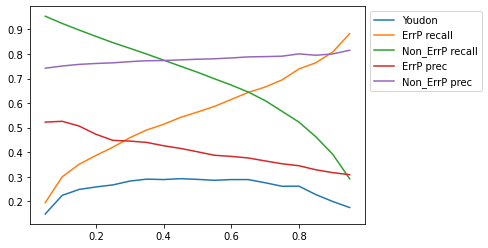

In [ ]:
plt.plot(np.linspace(0.05,0.95,19),pd.DataFrame(all_evaluation_means,columns=cols)['Youdon'])
plt.plot(np.linspace(0.05,0.95,19),pd.DataFrame(all_evaluation_means,columns=cols)['ErrP recall'])
plt.plot(np.linspace(0.05,0.95,19),pd.DataFrame(all_evaluation_means,columns=cols)['Non_ErrP recall'])
plt.plot(np.linspace(0.05,0.95,19),pd.DataFrame(all_evaluation_means,columns=cols)['ErrP prec'])
plt.plot(np.linspace(0.05,0.95,19),pd.DataFrame(all_evaluation_means,columns=cols)['Non_ErrP prec'])
plt.legend(['Youdon','ErrP recall','Non_ErrP recall','ErrP prec','Non_ErrP prec'],loc='best',bbox_to_anchor=(1,1))

In [ ]:
test = []
for i in grid_search:
    test.append(i[0:2])

cols = ['ErrP prec', 'Non_ErrP prec', 'ErrP recall', 'Non_ErrP recall', 'ErrP f', 'Non_ErrP f', 'weighted prec', 'weighted recall', 'weighted_f', 'auc','TP','FP','TN','FN']

Summary = pd.concat([pd.DataFrame(test[0][1],columns=cols).mean(), 
           pd.DataFrame(test[1][1],columns=cols).mean(),
           pd.DataFrame(test[2][1],columns=cols).mean(),
           pd.DataFrame(test[3][1],columns=cols).mean(),
           pd.DataFrame(test[4][1],columns=cols).mean(),
           pd.DataFrame(test[5][1],columns=cols).mean(),
           pd.DataFrame(all_evaluation_ShortUNET[0],columns=cols).mean()
           ], axis=1)
Summary.columns = [test[0][0],test[1][0],test[2][0],test[3][0],test[4][0],test[5][0],'ShortUnet 10 0.0001']
Summary

,10 0.001,10 0.0001,10 1e-05,20 0.001,20 0.0001,20 1e-05,ShortUnet 10 0.0001
ErrP prec,0.616715,0.660495,0.532497,0.579476,0.676172,0.495722,0.650756
Non_ErrP prec,0.823582,0.807359,0.775800,0.825495,0.802727,0.776386,0.810883
ErrP recall,0.571475,0.447370,0.265657,0.544027,0.443628,0.291931,0.416857
Non_ErrP recall,0.839244,0.909155,0.923308,0.843124,0.906507,0.923058,0.892144
ErrP f,0.566627,0.488271,0.313804,0.540241,0.480761,0.336569,0.466318
Non_ErrP f,0.828426,0.852656,0.838337,0.832547,0.848103,0.839343,0.845511
weighted prec,0.720149,0.733927,0.654149,0.702485,0.739449,0.636054,0.730820
weighted recall,0.705360,0.678262,0.594482,0.693576,0.675067,0.607494,0.654501
weighted_f,0.697526,0.670464,0.576070,0.686394,0.664432,0.587956,0.655915
auc,0.763229,0.785128,0.745413,0.779230,0.791060,0.735143,0.795759


In [ ]:
Summary['Short 10 reduced dim 0.0001'] = pd.DataFrame(all_evaluation_ShortUNET_20_red_dim[0],columns=cols).mean()
Summary

,10 0.001,10 0.0001,10 1e-05,20 0.001,20 0.0001,20 1e-05,ShortUnet 10 0.0001,Short 20 0.0001,Short 20 reduced dim 0.0001
ErrP prec,0.616715,0.660495,0.532497,0.579476,0.676172,0.495722,0.650756,0.686855,0.558690
Non_ErrP prec,0.823582,0.807359,0.775800,0.825495,0.802727,0.776386,0.810883,0.799281,0.793492
ErrP recall,0.571475,0.447370,0.265657,0.544027,0.443628,0.291931,0.416857,0.417197,0.361738
Non_ErrP recall,0.839244,0.909155,0.923308,0.843124,0.906507,0.923058,0.892144,0.901799,0.877215
ErrP f,0.566627,0.488271,0.313804,0.540241,0.480761,0.336569,0.466318,0.480593,0.393883
Non_ErrP f,0.828426,0.852656,0.838337,0.832547,0.848103,0.839343,0.845511,0.843842,0.829082
weighted prec,0.720149,0.733927,0.654149,0.702485,0.739449,0.636054,0.730820,0.743068,0.676091
weighted recall,0.705360,0.678262,0.594482,0.693576,0.675067,0.607494,0.654501,0.659498,0.619477
weighted_f,0.697526,0.670464,0.576070,0.686394,0.664432,0.587956,0.655915,0.662218,0.611482
auc,0.763229,0.785128,0.745413,0.779230,0.791060,0.735143,0.795759,0.788034,0.750636


In [ ]:
pd.DataFrame(all_evaluation_ShortUNET_20_red_dim[0],columns=cols).mean()

ErrP prec            0.650756
Non_ErrP prec        0.810883
ErrP recall          0.416857
Non_ErrP recall      0.892144
ErrP f               0.466318
Non_ErrP f           0.845511
weighted prec        0.730820
weighted recall      0.654501
weighted_f           0.655915
auc                  0.795759
TP                  31.884615
FP                  15.423077
TN                 159.000000
FN                  33.692308
dtype: float64

In [ ]:
all_evaluation_ShortUNET_20_red_dim = Neural_loop_gr_search(ShortUNet_red_dim().to(device),train_loop_UNet,1e-4, 10,Unet=True)

In [ ]:
pd.DataFrame(all_evaluation_UNET,columns=cols).mean()
plot_hist(make_preds(UNET_model,xtest),ytest)

ErrP prec           0.746567
Non_ErrP prec       0.703872
ErrP recall         0.311765
Non_ErrP recall     0.902195
ErrP f              0.407556
Non_ErrP f          0.786166
weighted prec       0.725219
weighted recall     0.606980
weighted_f          0.596861
auc                 0.747263
TP                 13.653846
FP                  4.538462
TN                 59.192308
FN                 22.615385
dtype: float64

####Results CNN-LSTM

In [ ]:
all_evaluation_cnn_lstm = Neural_loop(BaseCNN().to(device),cnn_lstm_train_loop,epochs,Unet=False)

In [ ]:
pd.DataFrame(all_evaluation_cnn_lstm,columns=cols).mean()

ErrP prec           0.686948
Non_ErrP prec       0.730933
ErrP recall         0.457880
Non_ErrP recall     0.831502
ErrP f              0.522519
Non_ErrP f          0.772895
weighted prec       0.708941
weighted recall     0.644691
weighted_f          0.647707
auc                 0.741011
TP                 18.307692
FP                  8.730769
TN                 55.000000
FN                 17.961538
dtype: float64

In [ ]:
def replicate(clf, num_to_rep, NN = 0):

    means = []
    cols = ['ErrP prec', 'Non_ErrP prec', 'ErrP recall', 'Non_ErrP recall', 'ErrP f', 'Non_ErrP f', 'weighted prec', 'weighted recall', 'weighted_f', 'auc','TP','FP','TN','FN']

    for i in range(num_to_rep):
        print("Iteration: " + str(i+1))
        if NN == 0:
            evaluation = train_loop(clf)
        else:
            evaluation = Neural_loop()             

        mean = pd.DataFrame(evaluation,columns = cols).mean()
        means.append(mean)
    
    return means

###Results and t-tests

In [ ]:
train_loop(clf_lda,0)[0]

In [ ]:
def get_cross_results(subject_num):
    uni_sub, _ = train_loop(clf_uniform,subject_num)
    mostf_sub, _ = train_loop(clf_most_f,subject_num)
    lda_sub, _ = train_loop(clf_lda,subject_num)
    cnn_sub, _, _ = Neural_loop(BaseCNN().to(device),subject_num,cnn_lstm_train_loop,1e-4,10,False,0.5)
    unet_sub, _ = Neural_loop(UNet().to(device),subject_num,train_loop_UNet,1e-4,10,True,0.5)

    return uni_sub, mostf_sub, lda_sub, cnn_sub, unet_sub

all_subject_cross_val = []

for i in range(26):
    print(">>>>>> subject: " + str(i))
    all_subject_cross_val.append(get_cross_results(i))

>>>>>> subject: 0
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6092, Val loss: 0.7155, Time epoch: 1.84
=>Epoch: 10 Train loss: 0.0194, Val loss: 2.0197, Time epoch: 12.92
Fold: 1
=>Epoch: 1 Train loss: 0.6305, Val loss: 0.6424, Time epoch: 1.43
=>Epoch: 10 Train loss: 0.0078, Val loss: 2.3043, Time epoch: 12.73
Fold: 2
=>Epoch: 1 Train loss: 0.6449, Val loss: 0.5877, Time epoch: 1.41
=>Epoch: 10 Train loss: 0.0430, Val loss: 0.5676, Time epoch: 12.84
Fold: 3
=>Epoch: 1 Train loss: 0.6425, Val loss: 0.5648, Time epoch: 1.42
=>Epoch: 10 Train loss: 0.0031, Val loss: 1.5041, Time epoch: 12.68
Fold: 4
=>Epoch: 1 Train loss: 0.6345, Val loss: 0.6519, Time epoch: 1.42
=>Epoch: 10 Train loss: 0.0005, Val loss: 1.1204, Time epoch: 12.82
Fold: 0
=>Epoch: 1 Train loss: 0.4849, Val loss: 0.6589, Time epoch: 1.06
=>Epoch: 10 Train loss: 0.1619, Val loss: 0.4434, Time epoch: 9.67
Fold: 1
=>Epoch: 1 Train loss: 0.5027, Val loss: 0.6413, Time epoch: 1.07
=>Epoch: 10 Train loss: 0.1506, Val loss: 0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.2317, Val loss: 0.2919, Time epoch: 1.43
=>Epoch: 10 Train loss: 0.0065, Val loss: 1.4721, Time epoch: 13.04
Fold: 1
=>Epoch: 1 Train loss: 0.2277, Val loss: 0.3703, Time epoch: 1.45
=>Epoch: 10 Train loss: 0.0524, Val loss: 1.0545, Time epoch: 13.02
Fold: 2
=>Epoch: 1 Train loss: 0.2752, Val loss: 0.1770, Time epoch: 1.45
=>Epoch: 10 Train loss: 0.1214, Val loss: 0.1566, Time epoch: 12.96
Fold: 3
=>Epoch: 1 Train loss: 0.2994, Val loss: 0.1120, Time epoch: 1.44
=>Epoch: 10 Train loss: 0.1220, Val loss: 0.1178, Time epoch: 13.05
Fold: 4
=>Epoch: 1 Train loss: 0.2933, Val loss: 0.1315, Time epoch: 1.45
=>Epoch: 10 Train loss: 0.0644, Val loss: 0.1719, Time epoch: 13.02
Fold: 0
=>Epoch: 1 Train loss: 0.3618, Val loss: 0.3695, Time epoch: 1.12
=>Epoch: 10 Train loss: 0.1280, Val loss: 0.4399, Time epoch: 10.15
Fold: 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=>Epoch: 1 Train loss: 0.3930, Val loss: 0.3731, Time epoch: 1.13
=>Epoch: 10 Train loss: 0.1318, Val loss: 0.5958, Time epoch: 10.15
Fold: 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=>Epoch: 1 Train loss: 0.3851, Val loss: 0.3155, Time epoch: 1.13
=>Epoch: 10 Train loss: 0.1379, Val loss: 0.1702, Time epoch: 10.20
Fold: 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=>Epoch: 1 Train loss: 0.3815, Val loss: 0.3727, Time epoch: 1.14
=>Epoch: 10 Train loss: 0.1435, Val loss: 0.1005, Time epoch: 10.23
Fold: 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=>Epoch: 1 Train loss: 0.4101, Val loss: 0.3400, Time epoch: 1.13
=>Epoch: 10 Train loss: 0.1397, Val loss: 0.3492, Time epoch: 10.21
>>>>>> subject: 2
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.3520, Val loss: 0.2361, Time epoch: 1.46
=>Epoch: 10 Train loss: 0.0031, Val loss: 0.5498, Time epoch: 13.10
Fold: 1
=>Epoch: 1 Train loss: 0.3432, Val loss: 0.2868, Time epoch: 1.46
=>Epoch: 10 Train loss: 0.0138, Val loss: 1.0139, Time epoch: 13.04
Fold: 2
=>Epoch: 1 Train loss: 0.3489, Val loss: 0.2378, Time epoch: 1.46
=>Epoch: 10 Train loss: 0.0057, Val loss: 0.6831, Time epoch: 13.19
Fold: 3
=>Epoch: 1 Train loss: 0.3173, Val loss: 0.4288, Time epoch: 1.46
=>Epoch: 10 Train loss: 0.0086, Val loss: 0.8293, Time epoch: 13.09
Fold: 4
=>Epoch: 1 Train loss: 0.3525, Val loss: 0.2881, Time epoch: 1.45
=>Epoch: 10 Train loss: 0.0004, Val loss: 0.5606, Time epoch: 13.04
Fold: 0
=>Epoch: 1 Train loss: 0.4236, Val loss: 0.5374, Time epoch: 1.14
=>Epoch: 10 Train loss: 0.1504, Val loss: 0.1567, Time epoch: 10.32
Fold: 1
=>Epoch: 1 Train loss: 0.4118, Val loss: 0.4665, Time epoch: 1.15
=>Epoch: 10 Train loss: 0.1308, Va

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6355, Val loss: 0.5215, Time epoch: 1.57
=>Epoch: 10 Train loss: 0.1973, Val loss: 1.6828, Time epoch: 13.23
Fold: 1
=>Epoch: 1 Train loss: 0.6160, Val loss: 0.6210, Time epoch: 1.46
=>Epoch: 10 Train loss: 0.0513, Val loss: 1.9741, Time epoch: 13.24
Fold: 2
=>Epoch: 1 Train loss: 0.6080, Val loss: 0.6214, Time epoch: 1.58
=>Epoch: 10 Train loss: 0.0103, Val loss: 3.6373, Time epoch: 13.26
Fold: 3
=>Epoch: 1 Train loss: 0.6098, Val loss: 0.6678, Time epoch: 1.45
=>Epoch: 10 Train loss: 0.0643, Val loss: 1.6198, Time epoch: 13.23
Fold: 4
=>Epoch: 1 Train loss: 0.6038, Val loss: 0.6484, Time epoch: 1.46
=>Epoch: 10 Train loss: 0.0616, Val loss: 2.2352, Time epoch: 13.31
Fold: 0
=>Epoch: 1 Train loss: 0.6244, Val loss: 0.5827, Time epoch: 1.14
=>Epoch: 10 Train loss: 0.1401, Val loss: 0.4752, Time epoch: 10.38
Fold: 1
=>Epoch: 1 Train loss: 0.5940, Val loss: 0.6158, Time epoch: 1.16
=>Epoch: 10 Train loss: 0.1395, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6844, Val loss: 0.6409, Time epoch: 1.47
=>Epoch: 10 Train loss: 0.0019, Val loss: 1.9816, Time epoch: 13.27
Fold: 1
=>Epoch: 1 Train loss: 0.6707, Val loss: 0.6661, Time epoch: 1.47
=>Epoch: 10 Train loss: 0.0049, Val loss: 3.0329, Time epoch: 13.25
Fold: 2
=>Epoch: 1 Train loss: 0.6738, Val loss: 0.6379, Time epoch: 1.50
=>Epoch: 10 Train loss: 0.0018, Val loss: 3.0454, Time epoch: 13.39
Fold: 3
=>Epoch: 1 Train loss: 0.6761, Val loss: 0.6572, Time epoch: 1.46
=>Epoch: 10 Train loss: 0.0002, Val loss: 2.9675, Time epoch: 13.16
Fold: 4
=>Epoch: 1 Train loss: 0.6702, Val loss: 0.7915, Time epoch: 1.47
=>Epoch: 10 Train loss: 0.0201, Val loss: 3.3426, Time epoch: 13.33
Fold: 0
=>Epoch: 1 Train loss: 0.6609, Val loss: 0.6357, Time epoch: 1.19
=>Epoch: 10 Train loss: 0.1485, Val loss: 0.5158, Time epoch: 10.47
Fold: 1
=>Epoch: 1 Train loss: 0.6073, Val loss: 0.6885, Time epoch: 1.15
=>Epoch: 10 Train loss: 0.1466, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6947, Val loss: 0.6920, Time epoch: 1.60
=>Epoch: 10 Train loss: 0.0375, Val loss: 1.5042, Time epoch: 13.33
Fold: 1
=>Epoch: 1 Train loss: 0.6913, Val loss: 0.7170, Time epoch: 1.48
=>Epoch: 10 Train loss: 0.0267, Val loss: 1.8798, Time epoch: 13.37
Fold: 2
=>Epoch: 1 Train loss: 0.6921, Val loss: 0.7076, Time epoch: 1.49
=>Epoch: 10 Train loss: 0.0138, Val loss: 3.3674, Time epoch: 13.43
Fold: 3
=>Epoch: 1 Train loss: 0.6965, Val loss: 0.6876, Time epoch: 1.49
=>Epoch: 10 Train loss: 0.0703, Val loss: 1.9033, Time epoch: 13.47
Fold: 4
=>Epoch: 1 Train loss: 0.6944, Val loss: 0.7003, Time epoch: 1.48
=>Epoch: 10 Train loss: 0.0395, Val loss: 2.8422, Time epoch: 13.35
Fold: 0
=>Epoch: 1 Train loss: 0.6286, Val loss: 0.6500, Time epoch: 1.16
=>Epoch: 10 Train loss: 0.1588, Val loss: 0.4088, Time epoch: 10.54
Fold: 1
=>Epoch: 1 Train loss: 0.5971, Val loss: 0.6989, Time epoch: 1.16
=>Epoch: 10 Train loss: 0.1447, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6243, Val loss: 0.6204, Time epoch: 1.59
=>Epoch: 10 Train loss: 0.0056, Val loss: 0.8900, Time epoch: 13.44
Fold: 1
=>Epoch: 1 Train loss: 0.6263, Val loss: 0.6178, Time epoch: 1.50
=>Epoch: 10 Train loss: 0.1260, Val loss: 1.4696, Time epoch: 13.55
Fold: 2
=>Epoch: 1 Train loss: 0.6435, Val loss: 0.5386, Time epoch: 1.48
=>Epoch: 10 Train loss: 0.0805, Val loss: 1.5317, Time epoch: 13.57
Fold: 3
=>Epoch: 1 Train loss: 0.6245, Val loss: 0.6510, Time epoch: 1.50
=>Epoch: 10 Train loss: 0.0038, Val loss: 2.0074, Time epoch: 13.52
Fold: 4
=>Epoch: 1 Train loss: 0.6139, Val loss: 0.6801, Time epoch: 1.50
=>Epoch: 10 Train loss: 0.1259, Val loss: 0.3353, Time epoch: 13.53
Fold: 0
=>Epoch: 1 Train loss: 0.5593, Val loss: 0.6135, Time epoch: 1.17
=>Epoch: 10 Train loss: 0.1498, Val loss: 0.3193, Time epoch: 10.61
Fold: 1
=>Epoch: 1 Train loss: 0.4918, Val loss: 0.5933, Time epoch: 1.17
=>Epoch: 10 Train loss: 0.1499, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6689, Val loss: 0.5767, Time epoch: 1.55
=>Epoch: 10 Train loss: 0.0010, Val loss: 1.8747, Time epoch: 13.57
Fold: 1
=>Epoch: 1 Train loss: 0.6409, Val loss: 0.6768, Time epoch: 1.52
=>Epoch: 10 Train loss: 0.0749, Val loss: 4.2476, Time epoch: 13.62
Fold: 2
=>Epoch: 1 Train loss: 0.6439, Val loss: 0.6757, Time epoch: 1.50
=>Epoch: 10 Train loss: 0.0020, Val loss: 2.9569, Time epoch: 13.47
Fold: 3
=>Epoch: 1 Train loss: 0.6473, Val loss: 0.6527, Time epoch: 1.50
=>Epoch: 10 Train loss: 0.0013, Val loss: 1.9597, Time epoch: 13.66
Fold: 4
=>Epoch: 1 Train loss: 0.6507, Val loss: 0.6620, Time epoch: 1.50
=>Epoch: 10 Train loss: 0.0016, Val loss: 2.7617, Time epoch: 13.46
Fold: 0
=>Epoch: 1 Train loss: 0.6313, Val loss: 0.6697, Time epoch: 1.18
=>Epoch: 10 Train loss: 0.1412, Val loss: 0.3877, Time epoch: 10.78
Fold: 1
=>Epoch: 1 Train loss: 0.5904, Val loss: 0.6711, Time epoch: 1.20
=>Epoch: 10 Train loss: 0.1436, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6174, Val loss: 0.6004, Time epoch: 1.64
=>Epoch: 10 Train loss: 0.1140, Val loss: 2.1215, Time epoch: 13.80
Fold: 1
=>Epoch: 1 Train loss: 0.6034, Val loss: 0.6905, Time epoch: 1.54
=>Epoch: 10 Train loss: 0.0509, Val loss: 1.4775, Time epoch: 13.60
Fold: 2
=>Epoch: 1 Train loss: 0.6292, Val loss: 0.6235, Time epoch: 1.52
=>Epoch: 10 Train loss: 0.0630, Val loss: 1.4945, Time epoch: 13.81
Fold: 3
=>Epoch: 1 Train loss: 0.6279, Val loss: 0.5767, Time epoch: 1.50
=>Epoch: 10 Train loss: 0.0470, Val loss: 0.8241, Time epoch: 13.64
Fold: 4
=>Epoch: 1 Train loss: 0.6339, Val loss: 0.5657, Time epoch: 1.51
=>Epoch: 10 Train loss: 0.0893, Val loss: 1.1761, Time epoch: 13.80
Fold: 0
=>Epoch: 1 Train loss: 0.5509, Val loss: 0.6145, Time epoch: 1.21
=>Epoch: 10 Train loss: 0.1592, Val loss: 0.5362, Time epoch: 10.82
Fold: 1
=>Epoch: 1 Train loss: 0.5564, Val loss: 0.6505, Time epoch: 1.21
=>Epoch: 10 Train loss: 0.1450, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.5388, Val loss: 0.5149, Time epoch: 1.68
=>Epoch: 10 Train loss: 0.0007, Val loss: 2.1490, Time epoch: 13.76
Fold: 1
=>Epoch: 1 Train loss: 0.5629, Val loss: 0.4594, Time epoch: 1.53
=>Epoch: 10 Train loss: 0.0013, Val loss: 1.8397, Time epoch: 13.68
Fold: 2
=>Epoch: 1 Train loss: 0.5437, Val loss: 0.5128, Time epoch: 1.53
=>Epoch: 10 Train loss: 0.0022, Val loss: 1.1087, Time epoch: 14.05
Fold: 3
=>Epoch: 1 Train loss: 0.5221, Val loss: 0.5646, Time epoch: 1.55
=>Epoch: 10 Train loss: 0.0255, Val loss: 1.4845, Time epoch: 13.79
Fold: 4
=>Epoch: 1 Train loss: 0.5322, Val loss: 0.5745, Time epoch: 1.53
=>Epoch: 10 Train loss: 0.0236, Val loss: 1.0450, Time epoch: 13.95
Fold: 0
=>Epoch: 1 Train loss: 0.5362, Val loss: 0.5920, Time epoch: 1.21
=>Epoch: 10 Train loss: 0.1478, Val loss: 0.4713, Time epoch: 10.91
Fold: 1
=>Epoch: 1 Train loss: 0.5760, Val loss: 0.6127, Time epoch: 1.21
=>Epoch: 10 Train loss: 0.1456, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6192, Val loss: 0.5674, Time epoch: 1.67
=>Epoch: 10 Train loss: 0.1638, Val loss: 1.1961, Time epoch: 13.84
Fold: 1
=>Epoch: 1 Train loss: 0.6012, Val loss: 0.6290, Time epoch: 1.55
=>Epoch: 10 Train loss: 0.0457, Val loss: 2.4875, Time epoch: 13.92
Fold: 2
=>Epoch: 1 Train loss: 0.5931, Val loss: 0.6734, Time epoch: 1.54
=>Epoch: 10 Train loss: 0.0442, Val loss: 2.7054, Time epoch: 13.80
Fold: 3
=>Epoch: 1 Train loss: 0.6052, Val loss: 0.5909, Time epoch: 1.54
=>Epoch: 10 Train loss: 0.1922, Val loss: 1.5377, Time epoch: 13.89
Fold: 4
=>Epoch: 1 Train loss: 0.6111, Val loss: 0.5840, Time epoch: 1.53
=>Epoch: 10 Train loss: 0.1440, Val loss: 1.2634, Time epoch: 13.88
Fold: 0
=>Epoch: 1 Train loss: 0.6417, Val loss: 0.5757, Time epoch: 1.21
=>Epoch: 10 Train loss: 0.1634, Val loss: 0.5852, Time epoch: 11.09
Fold: 1
=>Epoch: 1 Train loss: 0.6494, Val loss: 0.6437, Time epoch: 1.21
=>Epoch: 10 Train loss: 0.1446, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.2489, Val loss: 0.2885, Time epoch: 1.68
=>Epoch: 10 Train loss: 0.0003, Val loss: 0.3215, Time epoch: 13.93
Fold: 1
=>Epoch: 1 Train loss: 0.2938, Val loss: 0.1936, Time epoch: 1.55
=>Epoch: 10 Train loss: 0.0003, Val loss: 0.0568, Time epoch: 13.90
Fold: 2
=>Epoch: 1 Train loss: 0.2770, Val loss: 0.1818, Time epoch: 1.56
=>Epoch: 10 Train loss: 0.0003, Val loss: 0.0025, Time epoch: 14.22
Fold: 3
=>Epoch: 1 Train loss: 0.2720, Val loss: 0.2391, Time epoch: 1.56
=>Epoch: 10 Train loss: 0.0003, Val loss: 0.1993, Time epoch: 14.04
Fold: 4
=>Epoch: 1 Train loss: 0.2773, Val loss: 0.1837, Time epoch: 1.54
=>Epoch: 10 Train loss: 0.0001, Val loss: 0.0001, Time epoch: 13.98
Fold: 0
=>Epoch: 1 Train loss: 0.3322, Val loss: 0.3868, Time epoch: 1.24
=>Epoch: 10 Train loss: 0.1530, Val loss: 0.1955, Time epoch: 11.14
Fold: 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=>Epoch: 1 Train loss: 0.4331, Val loss: 0.2824, Time epoch: 1.23
=>Epoch: 10 Train loss: 0.1501, Val loss: 0.0600, Time epoch: 11.15
Fold: 2
=>Epoch: 1 Train loss: 0.3619, Val loss: 0.3121, Time epoch: 1.23
=>Epoch: 10 Train loss: 0.1368, Val loss: 0.0527, Time epoch: 11.23
Fold: 3
=>Epoch: 1 Train loss: 0.3691, Val loss: 0.3783, Time epoch: 1.24
=>Epoch: 10 Train loss: 0.1397, Val loss: 0.1280, Time epoch: 11.19
Fold: 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=>Epoch: 1 Train loss: 0.3148, Val loss: 0.3696, Time epoch: 1.25
=>Epoch: 10 Train loss: 0.1317, Val loss: 0.0904, Time epoch: 11.19


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

>>>>>> subject: 12
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.3149, Val loss: 0.2436, Time epoch: 1.66
=>Epoch: 10 Train loss: 0.0423, Val loss: 0.3865, Time epoch: 14.22
Fold: 1
=>Epoch: 1 Train loss: 0.3214, Val loss: 0.2421, Time epoch: 1.56
=>Epoch: 10 Train loss: 0.0595, Val loss: 0.5927, Time epoch: 13.99
Fold: 2
=>Epoch: 1 Train loss: 0.2982, Val loss: 0.2893, Time epoch: 1.59
=>Epoch: 10 Train loss: 0.0033, Val loss: 0.8643, Time epoch: 14.08
Fold: 3
=>Epoch: 1 Train loss: 0.2747, Val loss: 0.3427, Time epoch: 1.56
=>Epoch: 10 Train loss: 0.0124, Val loss: 0.8057, Time epoch: 13.96
Fold: 4
=>Epoch: 1 Train loss: 0.3303, Val loss: 0.2360, Time epoch: 1.58
=>Epoch: 10 Train loss: 0.0397, Val loss: 0.6115, Time epoch: 14.18
Fold: 0
=>Epoch: 1 Train loss: 0.3951, Val loss: 0.4540, Time epoch: 1.24
=>Epoch: 10 Train loss: 0.1238, Val loss: 0.1617, Time epoch: 11.21
Fold: 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=>Epoch: 1 Train loss: 0.4302, Val loss: 0.3895, Time epoch: 1.26
=>Epoch: 10 Train loss: 0.1269, Val loss: 0.3157, Time epoch: 11.42
Fold: 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=>Epoch: 1 Train loss: 0.3603, Val loss: 0.4498, Time epoch: 1.24
=>Epoch: 10 Train loss: 0.1361, Val loss: 0.2859, Time epoch: 11.30
Fold: 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=>Epoch: 1 Train loss: 0.3562, Val loss: 0.4858, Time epoch: 1.26
=>Epoch: 10 Train loss: 0.1593, Val loss: 1.0360, Time epoch: 11.27
Fold: 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=>Epoch: 1 Train loss: 0.4863, Val loss: 0.3875, Time epoch: 1.26
=>Epoch: 10 Train loss: 0.1377, Val loss: 0.2840, Time epoch: 11.35


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

>>>>>> subject: 13
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6476, Val loss: 0.6214, Time epoch: 1.66
=>Epoch: 10 Train loss: 0.0115, Val loss: 2.7134, Time epoch: 14.31
Fold: 1
=>Epoch: 1 Train loss: 0.6400, Val loss: 0.7084, Time epoch: 1.54
=>Epoch: 10 Train loss: 0.0124, Val loss: 4.1103, Time epoch: 14.12
Fold: 2
=>Epoch: 1 Train loss: 0.6580, Val loss: 0.5773, Time epoch: 1.56
=>Epoch: 10 Train loss: 0.1467, Val loss: 2.3173, Time epoch: 14.28
Fold: 3
=>Epoch: 1 Train loss: 0.6379, Val loss: 0.6501, Time epoch: 1.58
=>Epoch: 10 Train loss: 0.0936, Val loss: 2.5838, Time epoch: 14.26
Fold: 4
=>Epoch: 1 Train loss: 0.6412, Val loss: 0.6991, Time epoch: 1.57
=>Epoch: 10 Train loss: 0.0713, Val loss: 1.9831, Time epoch: 14.26
Fold: 0
=>Epoch: 1 Train loss: 0.6228, Val loss: 0.6457, Time epoch: 1.25
=>Epoch: 10 Train loss: 0.1414, Val loss: 0.6552, Time epoch: 11.34
Fold: 1
=

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.5405, Val loss: 0.5119, Time epoch: 1.67
=>Epoch: 10 Train loss: 0.0003, Val loss: 1.5791, Time epoch: 14.53
Fold: 1
=>Epoch: 1 Train loss: 0.5838, Val loss: 0.3553, Time epoch: 1.59
=>Epoch: 10 Train loss: 0.0045, Val loss: 0.8563, Time epoch: 14.16
Fold: 2
=>Epoch: 1 Train loss: 0.4894, Val loss: 0.7191, Time epoch: 1.58
=>Epoch: 10 Train loss: 0.0145, Val loss: 2.0173, Time epoch: 14.49
Fold: 3
=>Epoch: 1 Train loss: 0.5431, Val loss: 0.4894, Time epoch: 1.57
=>Epoch: 10 Train loss: 0.0026, Val loss: 1.0639, Time epoch: 14.29
Fold: 4
=>Epoch: 1 Train loss: 0.5271, Val loss: 0.6049, Time epoch: 1.59
=>Epoch: 10 Train loss: 0.0006, Val loss: 1.9552, Time epoch: 14.32
Fold: 0
=>Epoch: 1 Train loss: 0.5175, Val loss: 0.6227, Time epoch: 1.28
=>Epoch: 10 Train loss: 0.1458, Val loss: 0.4819, Time epoch: 11.41
Fold: 1
=>Epoch: 1 Train loss: 0.5709, Val loss: 0.5033, Time epoch: 1.27
=>Epoch: 10 Train loss: 0.1516, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6765, Val loss: 0.7338, Time epoch: 1.71
=>Epoch: 10 Train loss: 0.0059, Val loss: 4.6555, Time epoch: 14.33
Fold: 1
=>Epoch: 1 Train loss: 0.6832, Val loss: 0.6711, Time epoch: 1.68
=>Epoch: 10 Train loss: 0.0015, Val loss: 3.5615, Time epoch: 14.48
Fold: 2
=>Epoch: 1 Train loss: 0.6886, Val loss: 0.6614, Time epoch: 1.60
=>Epoch: 10 Train loss: 0.0162, Val loss: 4.4777, Time epoch: 14.37
Fold: 3
=>Epoch: 1 Train loss: 0.6765, Val loss: 0.7038, Time epoch: 1.60
=>Epoch: 10 Train loss: 0.0311, Val loss: 4.1398, Time epoch: 14.48
Fold: 4
=>Epoch: 1 Train loss: 0.6871, Val loss: 0.6650, Time epoch: 1.60
=>Epoch: 10 Train loss: 0.0776, Val loss: 3.1094, Time epoch: 14.43
Fold: 0
=>Epoch: 1 Train loss: 0.6427, Val loss: 0.6914, Time epoch: 1.28
=>Epoch: 10 Train loss: 0.1271, Val loss: 0.8231, Time epoch: 11.61
Fold: 1
=>Epoch: 1 Train loss: 0.6598, Val loss: 0.6864, Time epoch: 1.27
=>Epoch: 10 Train loss: 0.1512, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.5018, Val loss: 0.5738, Time epoch: 1.71
=>Epoch: 10 Train loss: 0.0003, Val loss: 1.6298, Time epoch: 14.55
Fold: 1
=>Epoch: 1 Train loss: 0.5168, Val loss: 0.4165, Time epoch: 1.62
=>Epoch: 10 Train loss: 0.0002, Val loss: 2.1933, Time epoch: 14.50
Fold: 2
=>Epoch: 1 Train loss: 0.4964, Val loss: 0.5426, Time epoch: 1.61
=>Epoch: 10 Train loss: 0.0043, Val loss: 1.9488, Time epoch: 14.66
Fold: 3
=>Epoch: 1 Train loss: 0.5004, Val loss: 0.6158, Time epoch: 1.61
=>Epoch: 10 Train loss: 0.0007, Val loss: 1.4857, Time epoch: 14.43
Fold: 4
=>Epoch: 1 Train loss: 0.5344, Val loss: 0.3928, Time epoch: 1.60
=>Epoch: 10 Train loss: 0.0002, Val loss: 1.9993, Time epoch: 14.49
Fold: 0
=>Epoch: 1 Train loss: 0.5242, Val loss: 0.5779, Time epoch: 1.29
=>Epoch: 10 Train loss: 0.1346, Val loss: 0.5358, Time epoch: 11.67
Fold: 1
=>Epoch: 1 Train loss: 0.5040, Val loss: 0.6109, Time epoch: 1.30
=>Epoch: 10 Train loss: 0.1356, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=>Epoch: 1 Train loss: 0.5533, Val loss: 0.5344, Time epoch: 1.30
=>Epoch: 10 Train loss: 0.1381, Val loss: 0.4431, Time epoch: 11.79
>>>>>> subject: 17
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6989, Val loss: 0.6810, Time epoch: 1.74
=>Epoch: 10 Train loss: 0.0409, Val loss: 1.6003, Time epoch: 14.63
Fold: 1
=>Epoch: 1 Train loss: 0.6878, Val loss: 0.6713, Time epoch: 1.70
=>Epoch: 10 Train loss: 0.0509, Val loss: 1.6204, Time epoch: 14.67
Fold: 2
=>Epoch: 1 Train loss: 0.6872, Val loss: 0.7041, Time epoch: 1.62
=>Epoch: 10 Train loss: 0.0036, Val loss: 3.4378, Time epoch: 14.59
Fold: 3
=>Epoch: 1 Train loss: 0.6899, Val loss: 0.6870, Time epoch: 1.63
=>Epoch: 10 Train loss: 0.0447, Val loss: 2.0492, Time epoch: 14.74
Fold: 4
=>Epoch: 1 Train loss: 0.6912, Val loss: 0.6920, Time epoch: 1.62
=>Epoch: 10 Train loss: 0.0017, Val loss: 2.5561, Time epoch: 14.77
Fold: 0
=>Epoch: 1 Train loss: 0.6252, Val loss: 0.7624, Time epoch: 1.30
=>Epoch: 10 Train loss: 0.1584, Val loss: 0.8494, Time epoch: 11.81
Fold: 1
=>Epoch: 1 Train loss: 0.5833, Val loss: 0.6796, Time epoch: 1.32
=>Epoch: 10 Train loss: 0.1362, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.4630, Val loss: 0.4830, Time epoch: 1.80
=>Epoch: 10 Train loss: 0.0003, Val loss: 1.1049, Time epoch: 15.32
Fold: 1
=>Epoch: 1 Train loss: 0.4980, Val loss: 0.3745, Time epoch: 1.66
=>Epoch: 10 Train loss: 0.0112, Val loss: 0.0334, Time epoch: 15.12
Fold: 2
=>Epoch: 1 Train loss: 0.4545, Val loss: 0.5756, Time epoch: 1.70
=>Epoch: 10 Train loss: 0.0002, Val loss: 1.5591, Time epoch: 15.66
Fold: 3
=>Epoch: 1 Train loss: 0.4657, Val loss: 0.4523, Time epoch: 1.65
=>Epoch: 10 Train loss: 0.0051, Val loss: 1.7030, Time epoch: 14.92
Fold: 4
=>Epoch: 1 Train loss: 0.4757, Val loss: 0.3828, Time epoch: 1.65
=>Epoch: 10 Train loss: 0.0023, Val loss: 2.4737, Time epoch: 14.79
Fold: 0
=>Epoch: 1 Train loss: 0.4890, Val loss: 0.6280, Time epoch: 1.31
=>Epoch: 10 Train loss: 0.1499, Val loss: 0.3542, Time epoch: 12.02
Fold: 1
=>Epoch: 1 Train loss: 0.4796, Val loss: 0.5765, Time epoch: 1.32
=>Epoch: 10 Train loss: 0.1255, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6963, Val loss: 0.6852, Time epoch: 1.79
=>Epoch: 10 Train loss: 0.1271, Val loss: 1.4355, Time epoch: 15.56
Fold: 1
=>Epoch: 1 Train loss: 0.6913, Val loss: 0.7250, Time epoch: 1.80
=>Epoch: 10 Train loss: 0.0444, Val loss: 1.8609, Time epoch: 15.77
Fold: 2
=>Epoch: 1 Train loss: 0.6893, Val loss: 0.6939, Time epoch: 1.78
=>Epoch: 10 Train loss: 0.0652, Val loss: 1.5851, Time epoch: 15.69
Fold: 3
=>Epoch: 1 Train loss: 0.6981, Val loss: 0.6889, Time epoch: 1.68
=>Epoch: 10 Train loss: 0.0753, Val loss: 1.4489, Time epoch: 15.22
Fold: 4
=>Epoch: 1 Train loss: 0.6916, Val loss: 0.6956, Time epoch: 1.71
=>Epoch: 10 Train loss: 0.1122, Val loss: 1.6839, Time epoch: 15.26
Fold: 0
=>Epoch: 1 Train loss: 0.6391, Val loss: 0.7040, Time epoch: 1.33
=>Epoch: 10 Train loss: 0.1393, Val loss: 0.5447, Time epoch: 12.09
Fold: 1
=>Epoch: 1 Train loss: 0.6167, Val loss: 0.6894, Time epoch: 1.33
=>Epoch: 10 Train loss: 0.1272, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.5754, Val loss: 0.5118, Time epoch: 1.78
=>Epoch: 10 Train loss: 0.0015, Val loss: 2.1349, Time epoch: 15.07
Fold: 1
=>Epoch: 1 Train loss: 0.5806, Val loss: 0.5307, Time epoch: 1.75
=>Epoch: 10 Train loss: 0.0017, Val loss: 0.7014, Time epoch: 15.52
Fold: 2
=>Epoch: 1 Train loss: 0.5759, Val loss: 0.5430, Time epoch: 1.70
=>Epoch: 10 Train loss: 0.0021, Val loss: 1.6267, Time epoch: 15.87
Fold: 3
=>Epoch: 1 Train loss: 0.5558, Val loss: 0.6256, Time epoch: 1.68
=>Epoch: 10 Train loss: 0.0046, Val loss: 2.1780, Time epoch: 15.16
Fold: 4
=>Epoch: 1 Train loss: 0.5515, Val loss: 0.6139, Time epoch: 1.68
=>Epoch: 10 Train loss: 0.0444, Val loss: 2.2895, Time epoch: 15.29
Fold: 0
=>Epoch: 1 Train loss: 0.4526, Val loss: 0.5150, Time epoch: 1.34
=>Epoch: 10 Train loss: 0.1268, Val loss: 0.3383, Time epoch: 12.23
Fold: 1
=>Epoch: 1 Train loss: 0.5026, Val loss: 0.5664, Time epoch: 1.37
=>Epoch: 10 Train loss: 0.1546, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.4205, Val loss: 0.4626, Time epoch: 1.82
=>Epoch: 10 Train loss: 0.0098, Val loss: 0.6476, Time epoch: 15.27
Fold: 1
=>Epoch: 1 Train loss: 0.4540, Val loss: 0.3765, Time epoch: 1.68
=>Epoch: 10 Train loss: 0.0097, Val loss: 0.5691, Time epoch: 15.20
Fold: 2
=>Epoch: 1 Train loss: 0.4328, Val loss: 0.4150, Time epoch: 1.73
=>Epoch: 10 Train loss: 0.0014, Val loss: 0.5338, Time epoch: 15.31
Fold: 3
=>Epoch: 1 Train loss: 0.4041, Val loss: 0.4826, Time epoch: 1.72
=>Epoch: 10 Train loss: 0.0018, Val loss: 1.0783, Time epoch: 15.41
Fold: 4
=>Epoch: 1 Train loss: 0.4508, Val loss: 0.2798, Time epoch: 1.83
=>Epoch: 10 Train loss: 0.0075, Val loss: 0.3903, Time epoch: 15.75
Fold: 0
=>Epoch: 1 Train loss: 0.4707, Val loss: 0.5795, Time epoch: 1.36
=>Epoch: 10 Train loss: 0.1259, Val loss: 0.1428, Time epoch: 12.33
Fold: 1
=>Epoch: 1 Train loss: 0.4542, Val loss: 0.5776, Time epoch: 1.36
=>Epoch: 10 Train loss: 0.1481, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.3337, Val loss: 0.1889, Time epoch: 1.79
=>Epoch: 10 Train loss: 0.0071, Val loss: 0.3868, Time epoch: 15.38
Fold: 1
=>Epoch: 1 Train loss: 0.3258, Val loss: 0.2891, Time epoch: 1.68
=>Epoch: 10 Train loss: 0.0009, Val loss: 0.5006, Time epoch: 15.22
Fold: 2
=>Epoch: 1 Train loss: 0.3297, Val loss: 0.2394, Time epoch: 1.69
=>Epoch: 10 Train loss: 0.0158, Val loss: 0.3070, Time epoch: 15.27
Fold: 3
=>Epoch: 1 Train loss: 0.3233, Val loss: 0.2342, Time epoch: 1.68
=>Epoch: 10 Train loss: 0.0171, Val loss: 0.5058, Time epoch: 15.29
Fold: 4
=>Epoch: 1 Train loss: 0.2932, Val loss: 0.4565, Time epoch: 1.71
=>Epoch: 10 Train loss: 0.0030, Val loss: 1.1730, Time epoch: 15.29
Fold: 0
=>Epoch: 1 Train loss: 0.3921, Val loss: 0.4329, Time epoch: 1.37
=>Epoch: 10 Train loss: 0.1410, Val loss: 0.0917, Time epoch: 12.36
Fold: 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=>Epoch: 1 Train loss: 0.4087, Val loss: 0.4249, Time epoch: 1.37
=>Epoch: 10 Train loss: 0.1344, Val loss: 0.1753, Time epoch: 12.37
Fold: 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=>Epoch: 1 Train loss: 0.3420, Val loss: 0.4646, Time epoch: 1.39
=>Epoch: 10 Train loss: 0.1371, Val loss: 0.1889, Time epoch: 12.49
Fold: 3
=>Epoch: 1 Train loss: 0.3417, Val loss: 0.5079, Time epoch: 1.39
=>Epoch: 10 Train loss: 0.1353, Val loss: 0.1884, Time epoch: 12.50
Fold: 4
=>Epoch: 1 Train loss: 0.3525, Val loss: 0.4861, Time epoch: 1.37
=>Epoch: 10 Train loss: 0.1318, Val loss: 0.3894, Time epoch: 12.44


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

>>>>>> subject: 23
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.2687, Val loss: 0.0541, Time epoch: 1.81
=>Epoch: 10 Train loss: 0.0002, Val loss: 0.2509, Time epoch: 15.31
Fold: 1
=>Epoch: 1 Train loss: 0.2581, Val loss: 0.1733, Time epoch: 1.71
=>Epoch: 10 Train loss: 0.0092, Val loss: 0.2982, Time epoch: 15.29
Fold: 2
=>Epoch: 1 Train loss: 0.2560, Val loss: 0.1736, Time epoch: 1.71
=>Epoch: 10 Train loss: 0.0008, Val loss: 0.9239, Time epoch: 15.28
Fold: 3
=>Epoch: 1 Train loss: 0.2485, Val loss: 0.2422, Time epoch: 1.73
=>Epoch: 10 Train loss: 0.0259, Val loss: 0.1547, Time epoch: 15.70
Fold: 4
=>Epoch: 1 Train loss: 0.2241, Val loss: 0.3007, Time epoch: 1.81
=>Epoch: 10 Train loss: 0.0066, Val loss: 0.4792, Time epoch: 15.43
Fold: 0
=>Epoch: 1 Train loss: 0.3633, Val loss: 0.2920, Time epoch: 1.37
=>Epoch: 10 Train loss: 0.1351, Val loss: 0.0123, Time epoch: 12.60
Fold: 1
=

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6332, Val loss: 0.5347, Time epoch: 1.84
=>Epoch: 10 Train loss: 0.0312, Val loss: 2.4427, Time epoch: 15.68
Fold: 1
=>Epoch: 1 Train loss: 0.6093, Val loss: 0.6395, Time epoch: 1.75
=>Epoch: 10 Train loss: 0.0031, Val loss: 2.3927, Time epoch: 15.57
Fold: 2
=>Epoch: 1 Train loss: 0.5770, Val loss: 0.9183, Time epoch: 1.78
=>Epoch: 10 Train loss: 0.0073, Val loss: 4.6260, Time epoch: 15.69
Fold: 3
=>Epoch: 1 Train loss: 0.6399, Val loss: 0.5130, Time epoch: 1.74
=>Epoch: 10 Train loss: 0.0006, Val loss: 1.9811, Time epoch: 15.77
Fold: 4
=>Epoch: 1 Train loss: 0.6178, Val loss: 0.5879, Time epoch: 1.77
=>Epoch: 10 Train loss: 0.0336, Val loss: 2.5942, Time epoch: 15.73
Fold: 0
=>Epoch: 1 Train loss: 0.5907, Val loss: 0.6042, Time epoch: 1.41
=>Epoch: 10 Train loss: 0.1505, Val loss: 0.4811, Time epoch: 12.67
Fold: 1
=>Epoch: 1 Train loss: 0.6127, Val loss: 0.6475, Time epoch: 1.41
=>Epoch: 10 Train loss: 0.1483, Val loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 0
=>Epoch: 1 Train loss: 0.6886, Val loss: 0.6584, Time epoch: 1.88
=>Epoch: 10 Train loss: 0.0049, Val loss: 2.4966, Time epoch: 15.74
Fold: 1
=>Epoch: 1 Train loss: 0.6744, Val loss: 0.7544, Time epoch: 1.73
=>Epoch: 10 Train loss: 0.0137, Val loss: 3.0435, Time epoch: 15.68
Fold: 2
=>Epoch: 1 Train loss: 0.6794, Val loss: 0.6891, Time epoch: 1.75
=>Epoch: 10 Train loss: 0.0058, Val loss: 2.9876, Time epoch: 15.76
Fold: 3
=>Epoch: 1 Train loss: 0.6727, Val loss: 0.6851, Time epoch: 1.77
=>Epoch: 10 Train loss: 0.0078, Val loss: 1.8842, Time epoch: 15.78
Fold: 4
=>Epoch: 1 Train loss: 0.6763, Val loss: 0.7018, Time epoch: 1.79
=>Epoch: 10 Train loss: 0.0003, Val loss: 2.6016, Time epoch: 15.62
Fold: 0
=>Epoch: 1 Train loss: 0.6117, Val loss: 0.7285, Time epoch: 1.40
=>Epoch: 10 Train loss: 0.1287, Val loss: 0.4946, Time epoch: 12.76
Fold: 1
=>Epoch: 1 Train loss: 0.6560, Val loss: 0.6803, Time epoch: 1.42
=>Epoch: 10 Train loss: 0.1486, Val loss: 

In [ ]:
#Save all the results to a single .csv file
pd.DataFrame(all_subject_cross_val).to_csv('all_cross_val_results.csv')

In [ ]:
#Requires a .csv file from the above. The file can be found in the github in "Code results" folder
all_subject_cross_val = pd.read_csv('all_cross_val_results.csv',index_col=0)

In [ ]:
#ast is used in order to convert arrays encoded as strings back into array in the csv file
import ast
#ast.literal_eval(all_subject_cross_val[0:1]['0'][0])

In [ ]:
uni_sub, mostf_sub, lda_sub, cnn_sub, unet_sub = all_subject_cross_val.iloc[0]
test = pd.DataFrame(ast.literal_eval(uni_sub),columns=cols)

test['mcc'] = (test['TP']*test['TN'] - test['FP']*test['FN'])/(((test['TP']+test['FP'])*(test['TP']+test['FN'])*(test['TN']+test['FP'])*(test['TN']+test['FN']))**(1/2))
print(test)
test.mean()

   ErrP prec  Non_ErrP prec  ErrP recall  ...  FN    Youdon       mcc
0   0.479167       0.596154     0.522727  ...  21  0.076299  0.075808
1   0.490909       0.622222     0.613636  ...  17  0.113636  0.113384
2   0.425532       0.547170     0.454545  ...  24 -0.027597 -0.027447
3   0.350877       0.441860     0.454545  ...  24 -0.206169 -0.206715
4   0.387755       0.509804     0.431818  ...  25 -0.103896 -0.103166

[5 rows x 16 columns]


ErrP prec           0.426848
Non_ErrP prec       0.543442
ErrP recall         0.495455
Non_ErrP recall     0.475000
ErrP f              0.457931
Non_ErrP f          0.506092
weighted prec       0.485145
weighted recall     0.485227
weighted_f          0.482012
auc                 0.500000
TP                 21.800000
FP                 29.400000
TN                 26.600000
FN                 22.200000
Youdon             -0.029545
mcc                -0.029627
dtype: float64

In [ ]:
uni_sub, mostf_sub, lda_sub, cnn_sub, unet_sub = all_subject_cross_val.iloc[0]
test = pd.DataFrame(ast.literal_eval(uni_sub),columns=cols)

test['mcc'] = (test['TP']*test['TN'] - test['FP']*test['FN'])/(((test['TP']+test['FP'])*(test['TP']+test['FN'])*(test['TN']+test['FP'])*(test['TN']+test['FN']))**(1/2))
print(test)
test.mean()

   ErrP prec  Non_ErrP prec  ErrP recall  ...  FN    Youdon       mcc
0   0.480769       0.604167     0.568182  ...  19  0.086039  0.085486
1   0.488889       0.600000     0.500000  ...  22  0.089286  0.089087
2   0.510204       0.627451     0.568182  ...  19  0.139610  0.138629
3   0.441860       0.561404     0.431818  ...  25  0.003247  0.003255
4   0.416667       0.538462     0.454545  ...  24 -0.045455 -0.045162

[5 rows x 16 columns]


ErrP prec           0.467678
Non_ErrP prec       0.586297
ErrP recall         0.504545
Non_ErrP recall     0.550000
ErrP f              0.484883
Non_ErrP f          0.567062
weighted prec       0.526987
weighted recall     0.527273
weighted_f          0.525972
auc                 0.500000
TP                 22.200000
FP                 25.200000
TN                 30.800000
FN                 21.800000
Youdon              0.054545
mcc                 0.054259
dtype: float64

In [ ]:
#ast.literal_eval(uni_sub)

In [ ]:
metric_list = ['ErrP prec', 'Non_ErrP prec', 'ErrP recall', 'Non_ErrP recall', 'auc', 'Youdon', 'mcc', 'ErrP f', 'Non_ErrP f', 'weighted_f']

In [ ]:
def make_mcc_in_df(pd_df):
    pd_df['mcc'] = (pd_df['TP']*pd_df['TN'] - pd_df['FP']*pd_df['FN'])/(((pd_df['TP']+pd_df['FP'])*(pd_df['TP']+pd_df['FN'])*(pd_df['TN']+pd_df['FP'])*(pd_df['TN']+pd_df['FN']))**(1/2))
    return pd_df

In [ ]:
moel = ['uni','mostf','lda','cnn','unet']

def get_mean_std(metric):
    mean_list = []
    std_list = []

    for i in range(26):
        uni_sub, mostf_sub, lda_sub, cnn_sub, unet_sub = all_subject_cross_val.iloc[i]

        uni_sub = pd.DataFrame(ast.literal_eval(uni_sub),columns=cols)
        mostf_sub = pd.DataFrame(ast.literal_eval(mostf_sub),columns=cols)
        lda_sub = pd.DataFrame(ast.literal_eval(lda_sub),columns=cols)
        cnn_sub = pd.DataFrame(ast.literal_eval(cnn_sub),columns=cols)
        unet_sub = pd.DataFrame(ast.literal_eval(unet_sub),columns=cols)

        if metric == 'mcc':
            uni_sub = make_mcc_in_df(uni_sub)
            mostf_sub = make_mcc_in_df(mostf_sub)
            lda_sub = make_mcc_in_df(lda_sub)
            cnn_sub = make_mcc_in_df(cnn_sub)
            unet_sub = make_mcc_in_df(unet_sub)

        uni_sub = uni_sub[metric]
        mostf_sub = mostf_sub[metric]
        lda_sub = lda_sub[metric]
        cnn_sub = cnn_sub[metric]
        unet_sub = unet_sub[metric]

        # uni_sub, mostf_sub, lda_sub, cnn_sub, unet_sub = all_subject_cross_val.values.tolist()[i]

        # uni_sub = pd.DataFrame(uni_sub,columns=cols)[metric]
        # mostf_sub = pd.DataFrame(mostf_sub,columns=cols)[metric]
        # lda_sub = pd.DataFrame(lda_sub,columns=cols)[metric]
        # cnn_sub = pd.DataFrame(cnn_sub,columns=cols)[metric]
        # unet_sub = pd.DataFrame(unet_sub,columns=cols)[metric]

        mean_list.append((uni_sub.mean(),mostf_sub.mean(),lda_sub.mean(),cnn_sub.mean(),unet_sub.mean()))
        std_list.append((uni_sub.std(),mostf_sub.std(),lda_sub.std(),cnn_sub.std(),unet_sub.std()))

    return pd.concat([pd.DataFrame(mean_list,columns=moel), pd.DataFrame(std_list,columns=moel)],axis=1)

for metric in metric_list:
    get_mean_std(metric).to_csv("mean and std_" + str(metric) + ".csv")

In [ ]:
from scipy import stats

moel = ['uni','mostf','lda','cnn','unet']

def get_shapiro_wilk(metric):
    pvals = []

    for i in range(26):
        uni_sub, mostf_sub, lda_sub, cnn_sub, unet_sub = all_subject_cross_val.iloc[i]
        
        uni_sub = pd.DataFrame(ast.literal_eval(uni_sub),columns=cols)
        mostf_sub = pd.DataFrame(ast.literal_eval(mostf_sub),columns=cols)
        lda_sub = pd.DataFrame(ast.literal_eval(lda_sub),columns=cols)
        cnn_sub = pd.DataFrame(ast.literal_eval(cnn_sub),columns=cols)
        unet_sub = pd.DataFrame(ast.literal_eval(unet_sub),columns=cols)

        if metric == 'mcc':
            uni_sub = make_mcc_in_df(uni_sub)
            mostf_sub = make_mcc_in_df(mostf_sub)
            lda_sub = make_mcc_in_df(lda_sub)
            cnn_sub = make_mcc_in_df(cnn_sub)
            unet_sub = make_mcc_in_df(unet_sub)

        uni_sub = uni_sub[metric]
        mostf_sub = mostf_sub[metric]
        lda_sub = lda_sub[metric]
        cnn_sub = cnn_sub[metric]
        unet_sub = unet_sub[metric]

        _, uni_pval = stats.shapiro(uni_sub)
        _, mostf_pval = stats.shapiro(mostf_sub)
        _, lda_pval = stats.shapiro(lda_sub)
        _, cnn_pval = stats.shapiro(cnn_sub)
        _, unet_pval = stats.shapiro(unet_sub)

        pvals.append((uni_pval, mostf_pval, lda_pval, cnn_pval, unet_pval))
        pd_pvals = pd.DataFrame(pvals)

    return pd_pvals

for metric in metric_list:
    get_shapiro_wilk(metric).to_csv("shapirowilk_" + str(metric) + ".csv")

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [ ]:
shap_test = pd.read_csv('all_cross_val_results.csv', index_col=False)
t = pd.DataFrame(ast.literal_eval(shap_test.iloc[20][3]),columns=cols)['auc']
a, b = stats.shapiro(t)
print(b)
print(t)

0.02514771744608879
0    0.817143
1    0.796484
2    0.783297
3    0.666813
4    0.812308
Name: auc, dtype: float64


In [ ]:
comparisons = ['lda_cnn','lda_unet','lda_uni','lda_mostf','cnn_unet','cnn_uni','cnn_mostf','unet_uni','unet_mostf']

def make_mannwhitney(metric):
    #print(metric)
    mannwhitney_results = []
    counter = 0
    for i in range(26):
        uni_sub, mostf_sub, lda_sub, cnn_sub, unet_sub = all_subject_cross_val.iloc[i]

        uni_sub = pd.DataFrame(ast.literal_eval(uni_sub),columns=cols)
        mostf_sub = pd.DataFrame(ast.literal_eval(mostf_sub),columns=cols)
        lda_sub = pd.DataFrame(ast.literal_eval(lda_sub),columns=cols)
        cnn_sub = pd.DataFrame(ast.literal_eval(cnn_sub),columns=cols)
        unet_sub = pd.DataFrame(ast.literal_eval(unet_sub),columns=cols)

        if metric == 'mcc':
            uni_sub = make_mcc_in_df(uni_sub)
            mostf_sub = make_mcc_in_df(mostf_sub)
            lda_sub = make_mcc_in_df(lda_sub)
            cnn_sub = make_mcc_in_df(cnn_sub)
            unet_sub = make_mcc_in_df(unet_sub)

        uni_sub = uni_sub[metric]
        mostf_sub = mostf_sub[metric]
        lda_sub = lda_sub[metric]
        cnn_sub = cnn_sub[metric]
        unet_sub = unet_sub[metric]

        #_, uni_pval = stats.shapiro(uni_sub)
        #_, mostf_pval = stats.shapiro(mostf_sub)
        #_, lda_pval = stats.shapiro(lda_sub)
        #_, cnn_pval = stats.shapiro(cnn_sub)
        #_, unet_pval = stats.shapiro(unet_sub)

        lda_cnn= stats.mannwhitneyu(lda_sub, cnn_sub)[1]
        lda_unet=stats.mannwhitneyu(lda_sub, unet_sub)[1]
        lda_uni=stats.mannwhitneyu(lda_sub, uni_sub)[1]
        lda_mostf=stats.mannwhitneyu(lda_sub, mostf_sub)[1]

        unet_uni=stats.mannwhitneyu(unet_sub, uni_sub)[1]
        #print("U: " , unet_sub)
        #print("Most: ", mostf_sub)
        try:
          unet_mostf=stats.mannwhitneyu(unet_sub, mostf_sub)[1]
        except:
          unet_mostf = 1.000
        cnn_unet=stats.mannwhitneyu(cnn_sub, unet_sub)[1]
        cnn_uni=stats.mannwhitneyu(cnn_sub, uni_sub)[1]
        cnn_mostf=stats.mannwhitneyu(cnn_sub, mostf_sub)[1]

        mannwhitney_results.append((lda_cnn,lda_unet,lda_uni,lda_mostf,cnn_unet,cnn_uni,cnn_mostf,unet_uni,unet_mostf))

    return pd.DataFrame(mannwhitney_results,columns=comparisons)

for metric in metric_list:
    make_mannwhitney(metric).to_csv("mannwhitney_" + str(metric) + ".csv")

###Cross domain test


In [ ]:
def get_cross_results():
    lda_sub, lda_model = train_loop_cross(clf_lda)
    # cnn_sub, cnn_model, cnn_states = Neural_loop_cross(BaseCNN().to(device),subject_num,cnn_lstm_train_loop,1e-4,10,False,0.5)
    # unet_sub, unet_model = Neural_loop_cross(UNet().to(device),subject_num,train_loop_UNet,1e-4,10,True,0.5)

    return lda_sub, lda_model#, cnn_sub, cnn_model, cnn_states, unet_sub, unet_model

all_lda_models = get_cross_results()

Sub: 0
Sub: 1
Sub: 2
Sub: 3
Sub: 4
Sub: 5
Sub: 6
Sub: 7
Sub: 8
Sub: 9
Sub: 10
Sub: 11
Sub: 12
Sub: 13
Sub: 14
Sub: 15
Sub: 16
Sub: 17
Sub: 18
Sub: 19
Sub: 20
Sub: 21
Sub: 22
Sub: 23
Sub: 24
Sub: 25


In [ ]:
all_lda_models

In [ ]:
f1_cross= np.zeros((26,26))

for i, model in enumerate(all_lda_models[1]):
    for j, sub in enumerate(all_subjects_cross):
        xtrain,ytrain,xtest,ytest, xval, yval = sub
        subject_pred = model.predict(xtest)
        subject_pred_probs = model.predict_proba(xtest)
        eval_metrics = evaluation(ytest, subject_pred, subject_pred_probs[:,-1])[8]
        f1_cross[i,j] = eval_metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
pd.DataFrame(f1_cross).to_csv('F1_matrix.csv')